### 前向扩散+后向去噪的整体代码（单比特、不测量辅助比特）

#### 代码思路：

加噪参数预定义；构建加噪，去噪电路（训练集）；定义损失函数，优化参数

去噪优化好后，构建每一步去噪测试函数（验证集），观察效果

构建从混态开始的去噪（测试集），观察效果

#### 代码规范：

每步的去噪训练由两部分代码组成：构建电路；定义损失函数，优化参数

去噪演示由一块代码完整构成

In [37]:
from qiskit import Aer
import numpy as np
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import SPSA

from qutip import Bloch, about, basis, destroy, sesolve, sigmax, sigmay, sigmaz, expect, Qobj
import matplotlib as mpl
import numpy as np
from matplotlib import cm

%matplotlib inline

0.6282152531035723


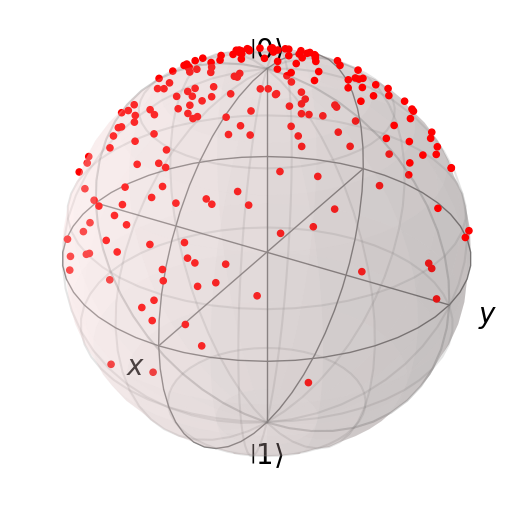

In [38]:
'''此处为加噪散点扩散演示'''
veclst=[]
totltime=5 #总时间
newrepeat = 200 #sample 个数
qbt = 1 #比特数
cir = [QuantumCircuit(1) for i in range(newrepeat)] # 构建sample个电路

for each in range(newrepeat):
    np.random.seed(each)
    for t in range(totltime): 
        thetalstdf = (np.random.rand(3*qbt)-0.5)*np.pi/2 # 随机旋转角度
        for i in range(qbt):
            cir[each].rz(thetalstdf[0],0) # 对比特施加随机旋转门
            cir[each].ry(thetalstdf[1],0)
            cir[each].rz(thetalstdf[2],0)
            cir[each].barrier([0])

    veclst.append(Statevector(cir[each])) #添加每个点的vector

#调用qutip画球面上的散点
b = Bloch()
newv=[]
for i in range(len(veclst)):
    newv.append(Qobj([[veclst[i][0]],[veclst[i][1]]]))
# xyz方向进行测量 ##
x=expect(sigmax(), newv)
y=expect(sigmay(), newv)
z=expect(sigmaz(), newv)
print(sum(z)/len(z))
b.add_points([x,y,z], "m")

# 绘制散点 ##
b.point_color = ['r']
b.point_marker = ["o"]
b.point_size = [20]
b.zlpos = [1.1, -1.2]
b.show()

In [39]:
'''先准备好相关参数'''
swapn = 5
theta_scale = np.pi/2 #控制加噪旋转门的旋转幅度
qbt = 1 #量子比特数
repeat = 50 # 互相独立的点,sample数量
mean = 25 # 在sample里随机抽取mean组做swap
veclst=[]
ttime = 5 #总时间

thetalst = [[] for t in range(ttime)] # 加噪角度参数 thetalst1[time][sample num]
for i in range(repeat):
    np.random.seed(i) #每个点diffusion不同
    for t in range(ttime):
        thetalst[t].append((np.random.rand(3*qbt)-0.5)*theta_scale)

print(thetalst[1][14])


[-0.77275805 -0.29886611  0.71880227]


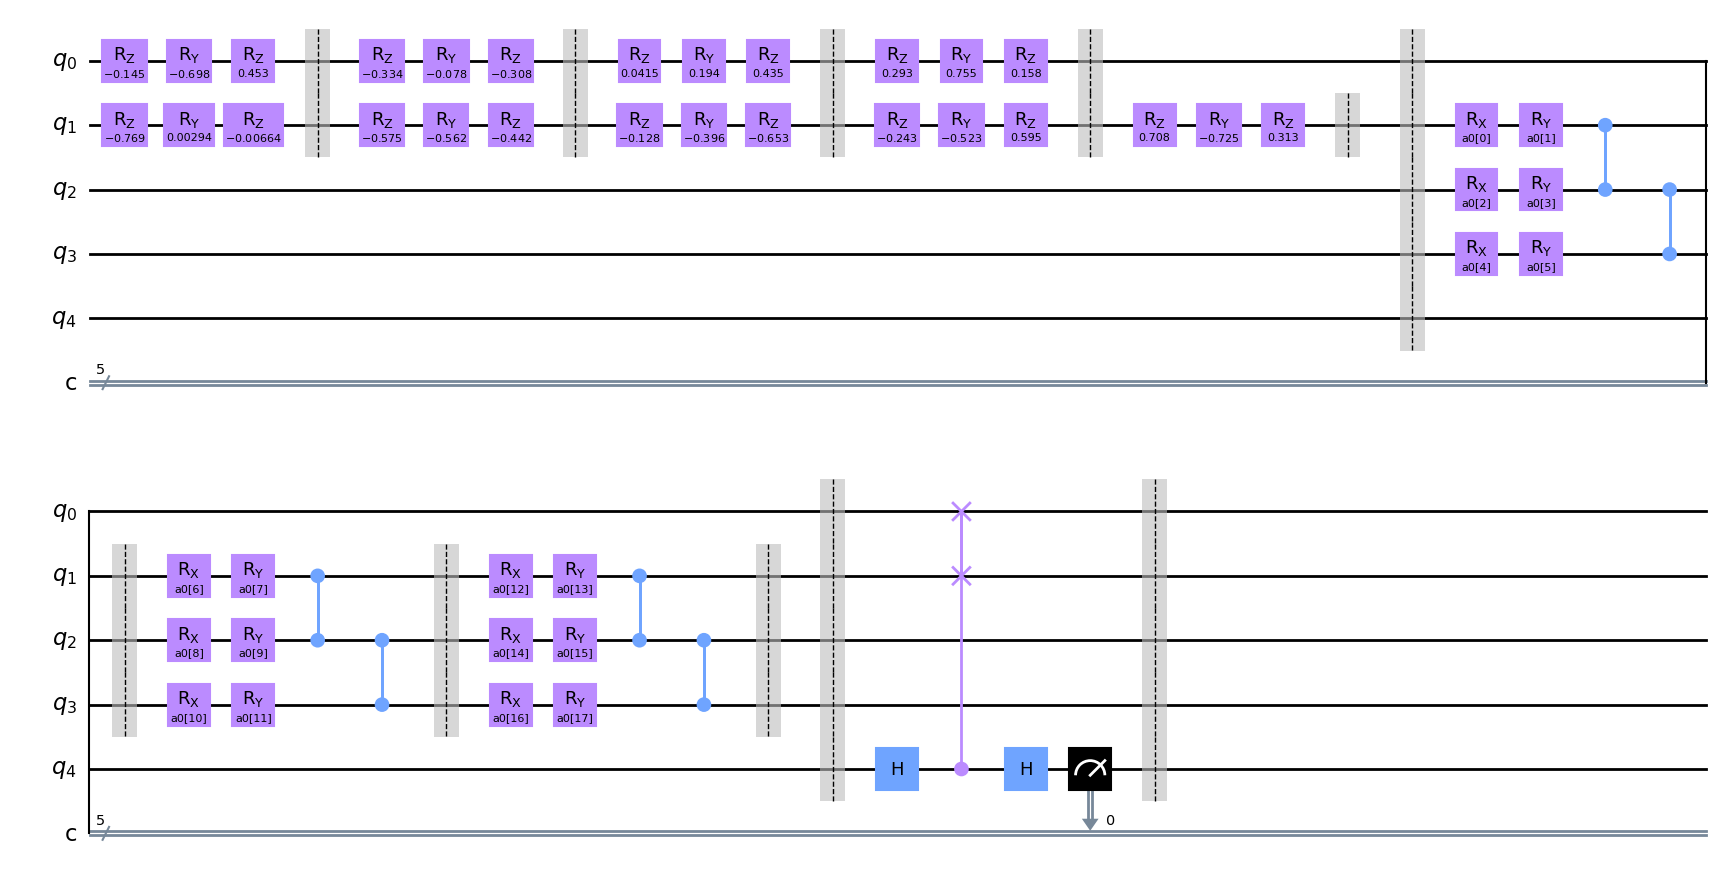

In [40]:
'''训练第一步去噪'''
circlst = [QuantumCircuit(swapn,5) for num in range(mean)] #构建电路/初始化
time=4

for each in range(mean):

    randcp = [np.random.randint(0,repeat) for i in range(2)] #随机选取加噪去噪对
    
    for t in range(time): # reference diffusion 加噪
        circlst[each].rz(thetalst[t][randcp[0]][0],0)
        circlst[each].ry(thetalst[t][randcp[0]][1],0)
        circlst[each].rz(thetalst[t][randcp[0]][2],0)
        circlst[each].barrier([0])

    for t in range(ttime): # total diffusion 整体加噪
        circlst[each].rz(thetalst[t][randcp[1]][0],1)
        circlst[each].ry(thetalst[t][randcp[1]][1],1)
        circlst[each].rz(thetalst[t][randcp[1]][2],1)
        circlst[each].barrier([1])

    circlst[each].barrier(np.arange(swapn))
    veclst.append(Statevector(circlst[each])) #添加每个点的vector

#denoising process 第一步的去噪
layers = 3
totalq = 3
thetalsta = [ParameterVector(f'a{each}',18) for each in range(mean)]

for each in range(mean):
    for n in range(layers):
        for i in range(totalq):
            circlst[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+1)
            circlst[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+1)
        for i in range(totalq):
            if i<totalq-1:
                circlst[each].cz(i+1,i+2)
        circlst[each].barrier(range(1,1+totalq))

    #swap test 检测去噪效果
    # circlst[each].measure([2,3],[1,2]) #测量辅助比特
    circlst[each].barrier(range(swapn))
    circlst[each].h(4)
    circlst[each].cswap(4,0,1)
    circlst[each].h(4)
    circlst[each].measure(4,0)
    circlst[each].barrier(range(swapn))
circlst[0].draw('mpl', style='iqp')

225.88
[ 0.15883498 -0.36994063  0.71066478  0.60793928  0.30626774  2.85450692
 -0.30284475  0.4247782  -1.14652805 -0.01628759  0.50154527 -2.80213181
 -0.40533146  0.34665959  0.22926686  1.21247331  0.80286689  3.11982876]
118.44


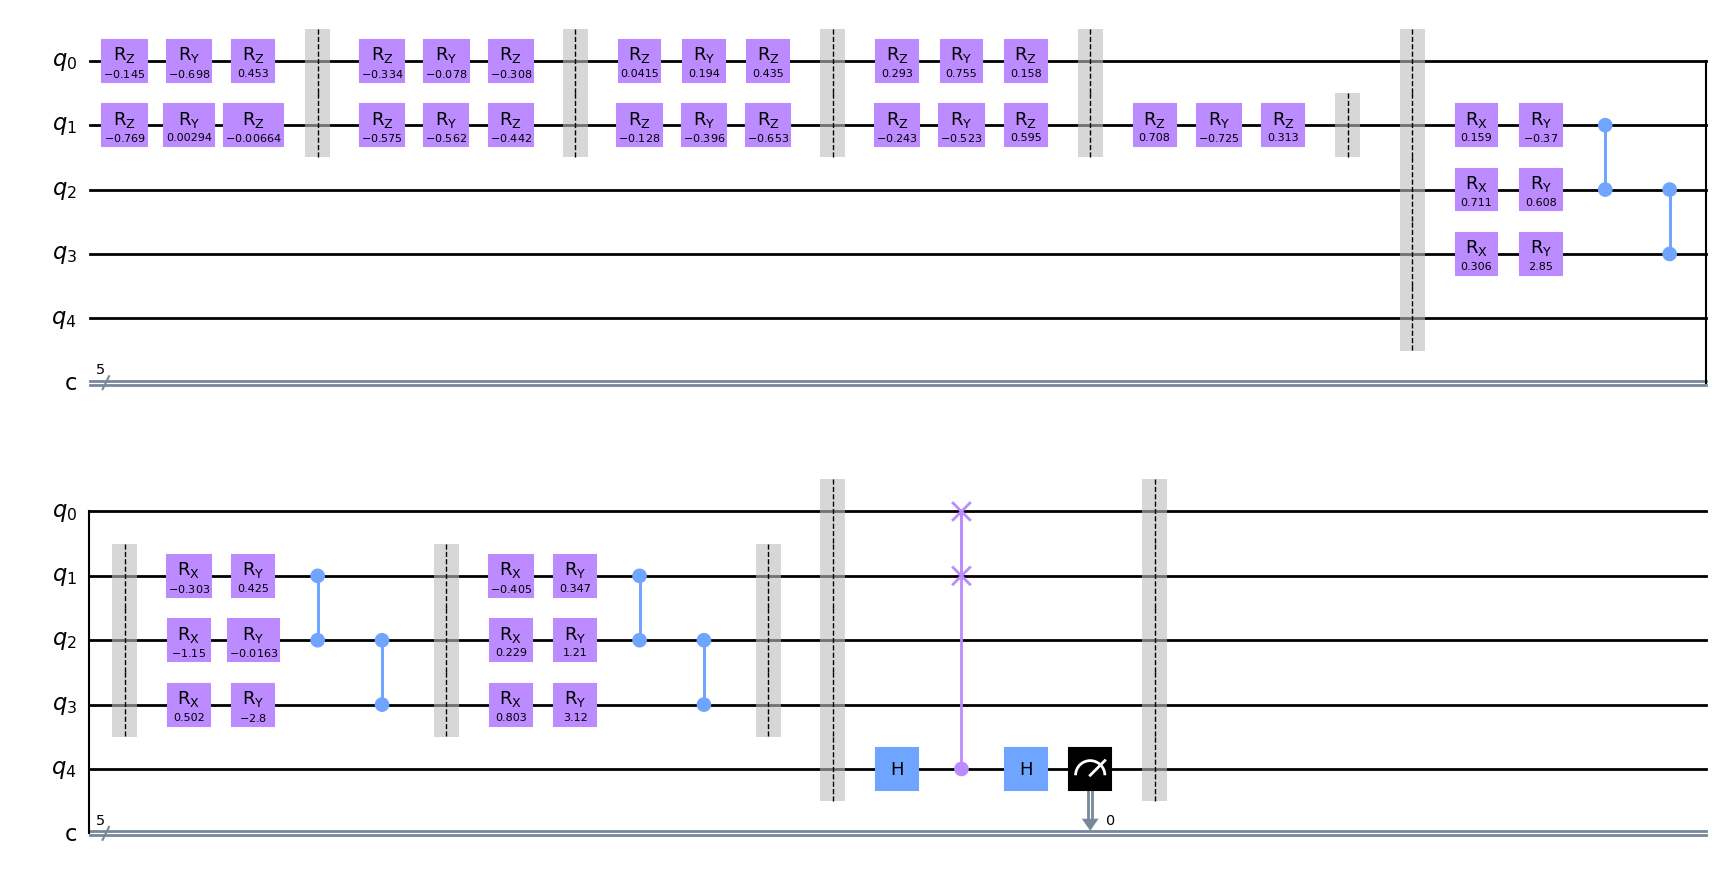

In [41]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

def cost_function_vqe(theta_range): #损失函数,这里xxxx0代表前向和后向重合,该值越大,去噪效果越好,因此需要最小xxxx1的频率
    count = 0
    for each in range(mean):
        circuits = circlst[each].assign_parameters({thetalsta[each]: theta_range})
        job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)

        result_sim = job_sim.result()
        counts = result_sim.get_counts(circuits)
        
        for i in counts.keys():
            if i[-1]=='1':
                count += counts[i]
    return count/mean

print(cost_function_vqe(np.random.randn(18))) 

### Optimizaion of denoising circuit parameters 优化参数

initial_theta = np.random.randn(18)
optimizer = SPSA(maxiter=200, blocking=True) # 可选参数如 maxiter=150, blocking=True 增强优化效果
optimizer_result = optimizer.minimize(fun=cost_function_vqe, x0=initial_theta)
optimal_parameters_1 = optimizer_result.x
print(optimal_parameters_1)
print(cost_function_vqe(optimal_parameters_1))

for each in range(mean):
    circlst[each] = circlst[each].assign_parameters({thetalsta[each]: optimal_parameters_1})
circlst[0].draw('mpl', style='iqp')

In [42]:
#最优化参数写入文件
# with open('opp1.txt','w') as f:
#     f.write(str(optimal_parameters_1))

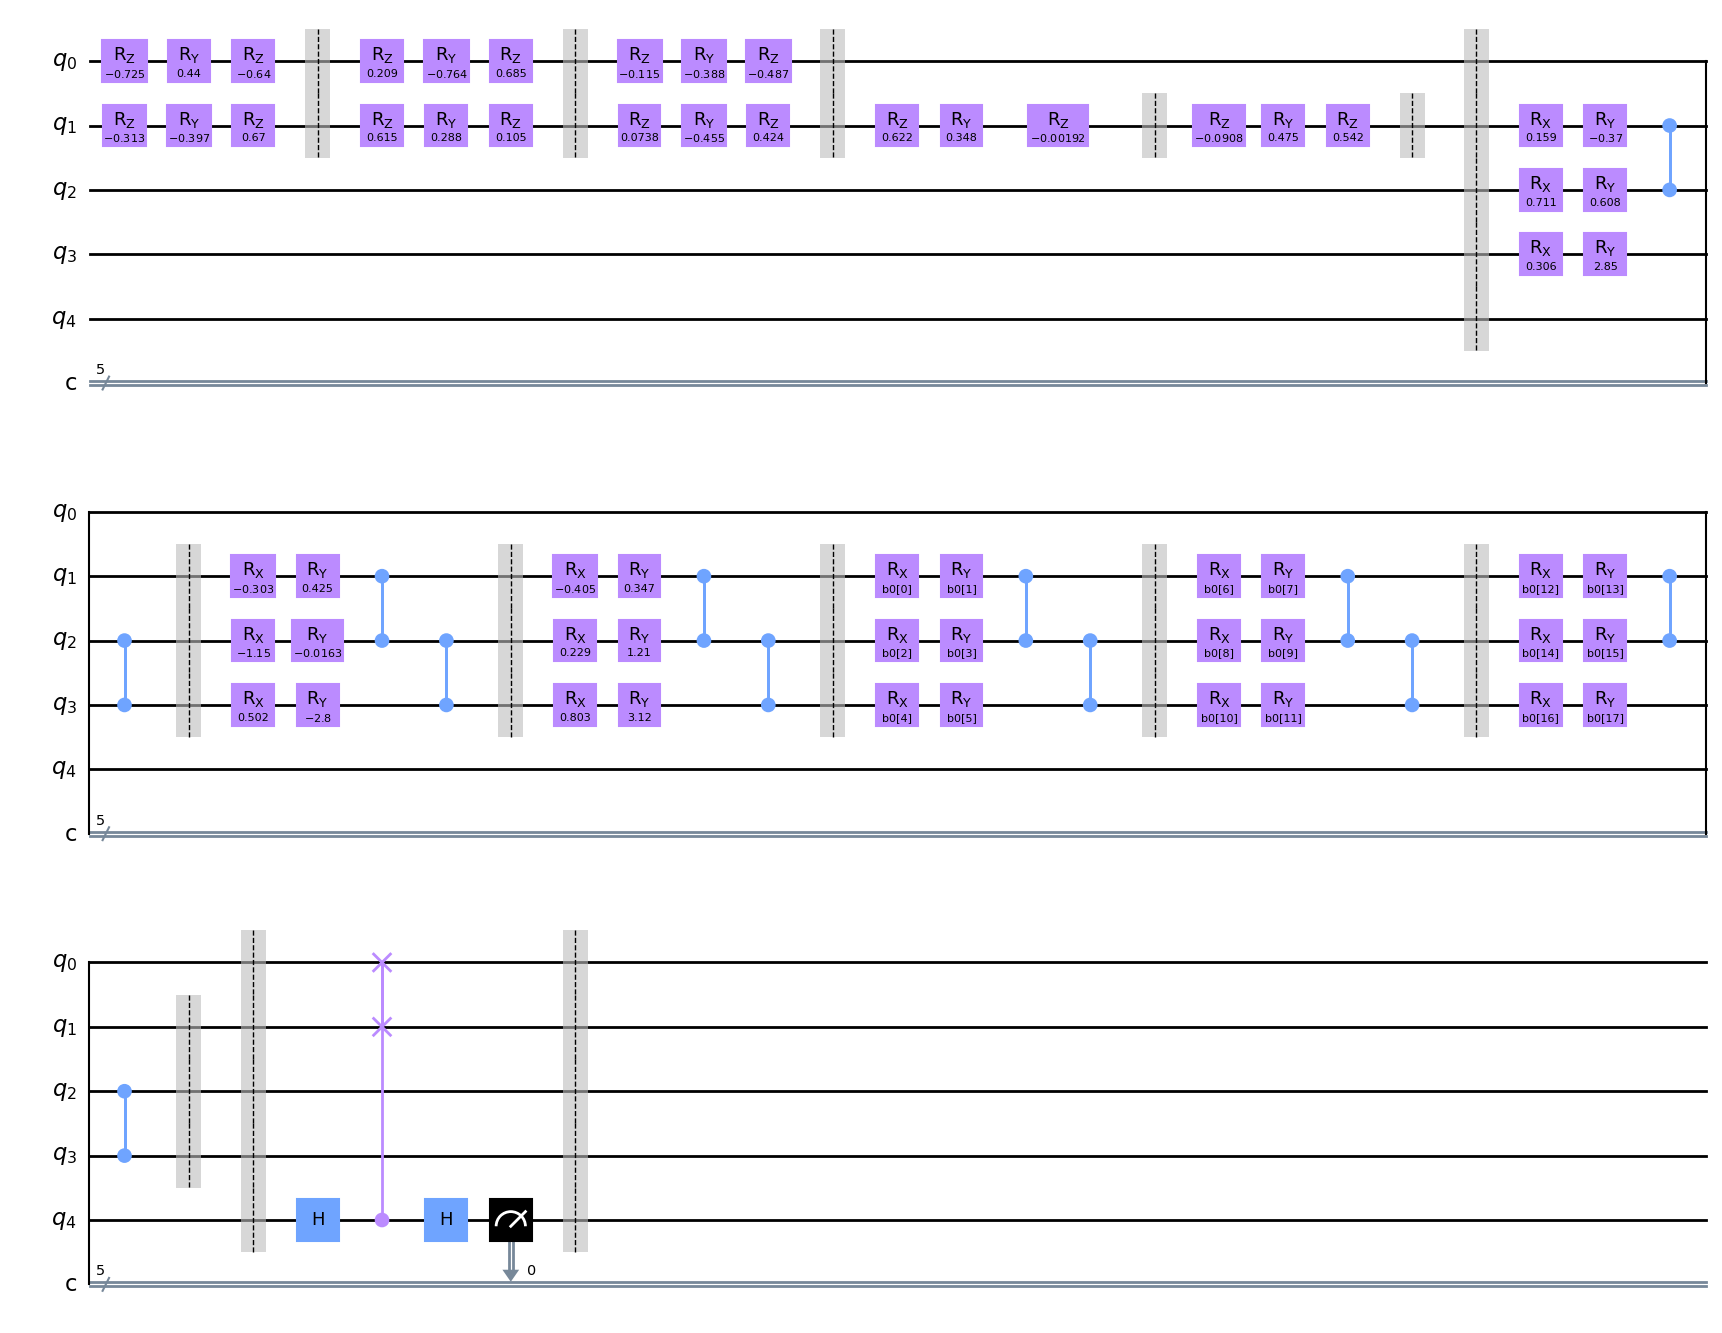

In [43]:
'''训练第二步去噪'''
time=3
circlst2 = [QuantumCircuit(swapn,5) for num in range(mean)] #每个点独立的电路

for each in range(mean):

    randcp = [np.random.randint(0,repeat) for i in range(2)] #随机选取加噪去噪对
    
    for t in range(time): # reference diffusion 加噪
        circlst2[each].rz(thetalst[t][randcp[0]][0],0)
        circlst2[each].ry(thetalst[t][randcp[0]][1],0)
        circlst2[each].rz(thetalst[t][randcp[0]][2],0)
        circlst2[each].barrier([0])

    for t in range(ttime): # total diffusion 整体加噪
        circlst2[each].rz(thetalst[t][randcp[1]][0],1)
        circlst2[each].ry(thetalst[t][randcp[1]][1],1)
        circlst2[each].rz(thetalst[t][randcp[1]][2],1)
        circlst2[each].barrier([1])

    circlst2[each].barrier(np.arange(swapn))
    veclst.append(Statevector(circlst2[each])) #添加每个点的vector

#denoising process 加入第一步去噪的结果
layers = 3
thetalsta = [ParameterVector(f'a{each}',18) for each in range(mean)]

for each in range(mean):

    for n in range(layers):
        for i in range(totalq):
            circlst2[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+1)
            circlst2[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+1)
        for i in range(totalq):
            if i<totalq-1:
                circlst2[each].cz(i+1,i+2)
        circlst2[each].barrier(range(1,1+totalq))

    circlst2[each] = circlst2[each].assign_parameters({thetalsta[each]: optimal_parameters_1})
# with open('opp1.txt', 'r') as f:
#     op1 = np.array(f.read())

#denoising process 第二步去噪
layers = 3
thetalstb = [ParameterVector(f'b{each}',18) for each in range(mean)]

for each in range(mean):
    for n in range(layers):
        for i in range(totalq):
            circlst2[each].rx(thetalstb[each][0+2*i+n*2*totalq],i+1)
            circlst2[each].ry(thetalstb[each][1+2*i+n*2*totalq],i+1)
        for i in range(totalq):
            if i<totalq-1:
                circlst2[each].cz(i+1,i+2)
        circlst2[each].barrier(range(1,1+totalq))


    #swap test
    # circlst2[each].measure([2,3],[1,2]) #测量辅助比特
    circlst2[each].barrier(range(swapn))
    circlst2[each].h(4)
    circlst2[each].cswap(4,0,1)
    circlst2[each].h(4)
    circlst2[each].measure(4,0)
    circlst2[each].barrier(range(swapn))
circlst2[0].draw('mpl', style='iqp')

[ 0.74602368 -1.85541769  2.39088504 -1.31474449 -2.78308036 -0.21145426
  1.5503583  -0.97894046 -0.0939768   1.46201067 -0.54513106  1.98620921
 -1.8724226   3.33691793  0.62845011 -2.31873865  0.56144274  0.37850531]
63.64


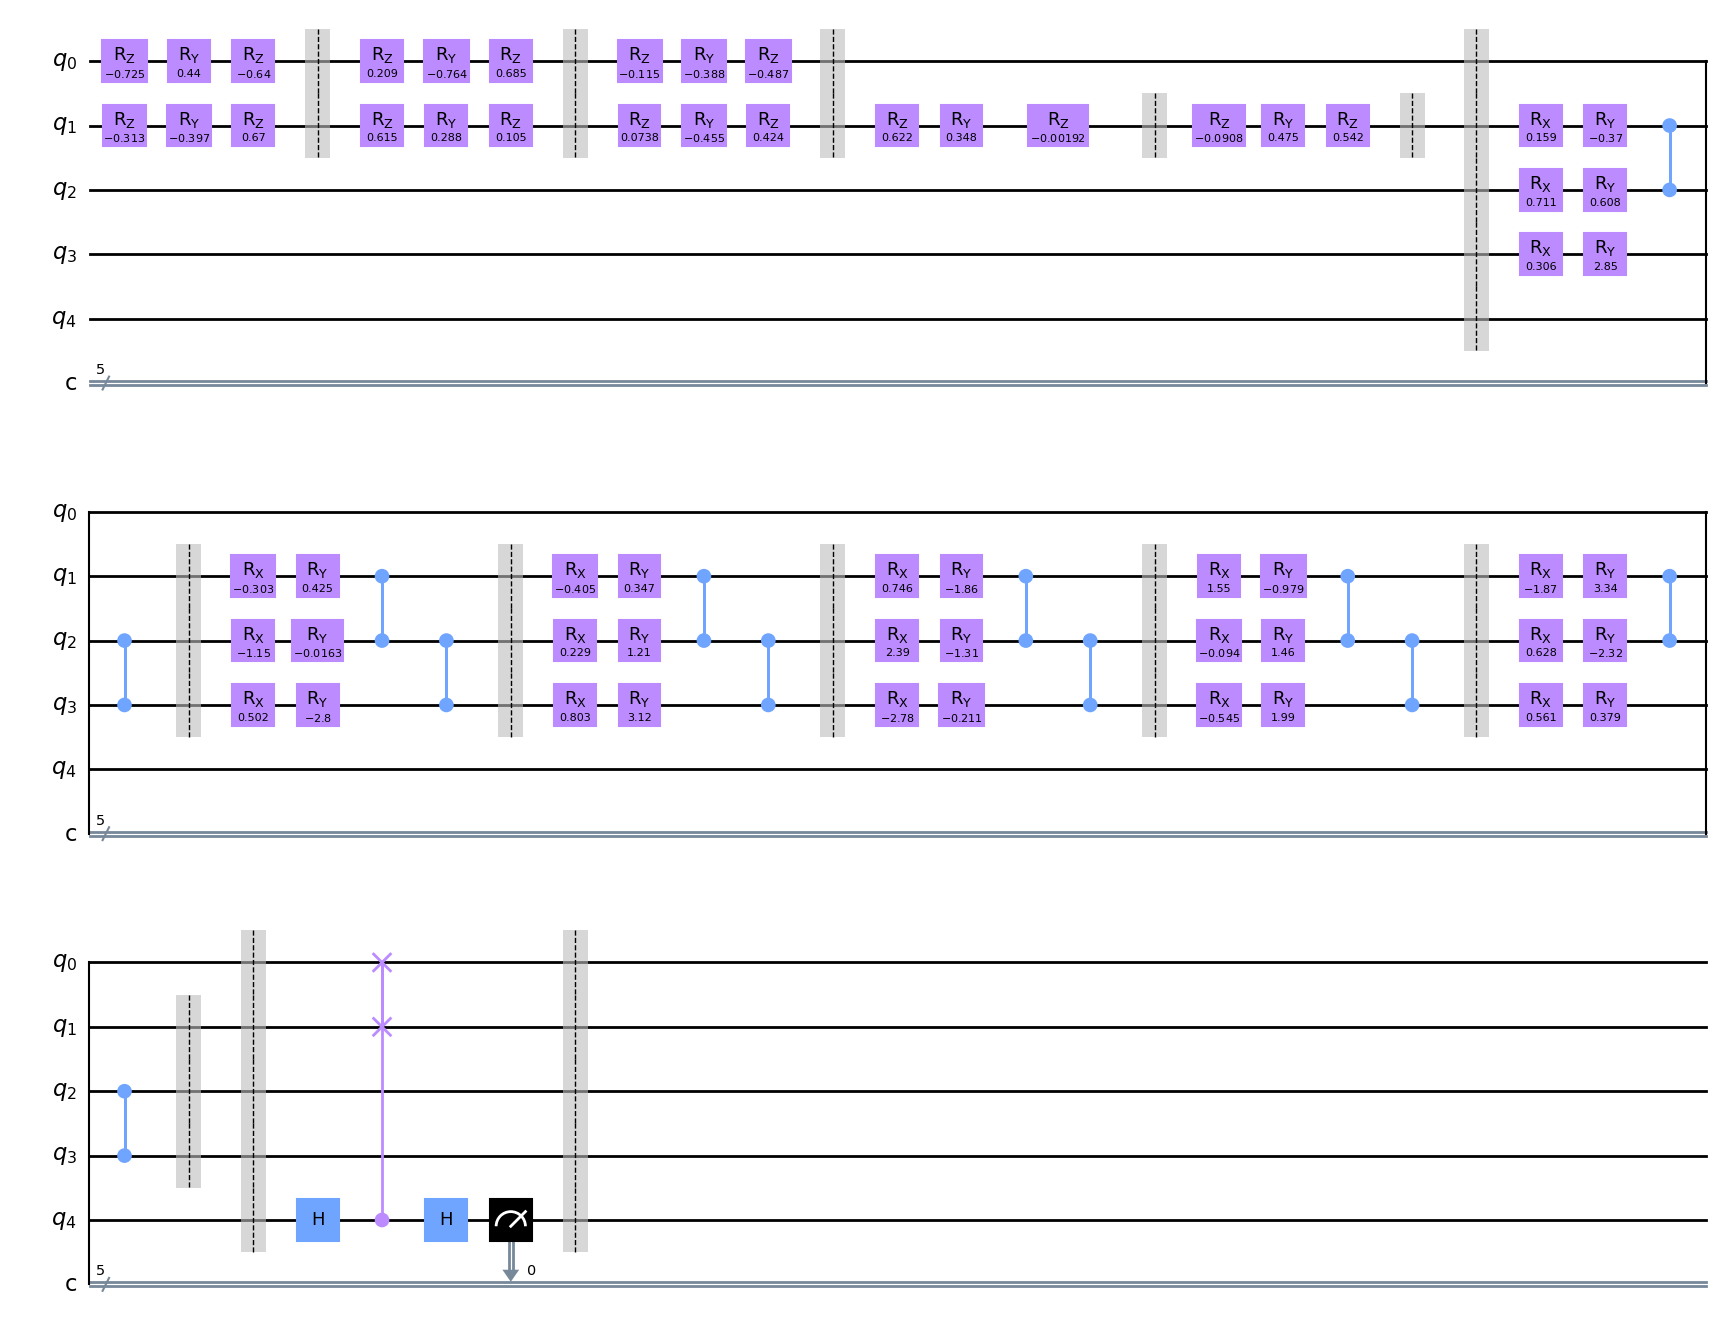

In [44]:
def cost_function_vqe_2(theta_range): #损失函数,这里xxxx0代表前向和后向重合,该值越大,去噪效果越好,因此需要最小xxxx1的频率
    count = 0
    for each in range(mean):
        circuits = circlst2[each].assign_parameters({thetalstb[each]: theta_range})
        job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)

        result_sim = job_sim.result()
        counts = result_sim.get_counts(circuits)

        for i in counts.keys():
            if i[-1]=='1':
                count += counts[i]
    return count/mean

### Optimizaion of denoising circuit parameters 优化参数
initial_theta = np.random.randn(18)
optimizer = SPSA(maxiter=200, blocking=True)

optimizer_result = optimizer.minimize(fun=cost_function_vqe_2, x0=initial_theta)
optimal_parameters_2 = optimizer_result.x

print(optimal_parameters_2)
print(cost_function_vqe_2(optimal_parameters_2))

for each in range(mean):
    circlst2[each] = circlst2[each].assign_parameters({thetalstb[each]: optimal_parameters_2})
circlst2[0].draw('mpl', style='iqp')

In [45]:
# with open('opp2.txt','w') as f:
#     f.write(str(optimal_parameters_2))

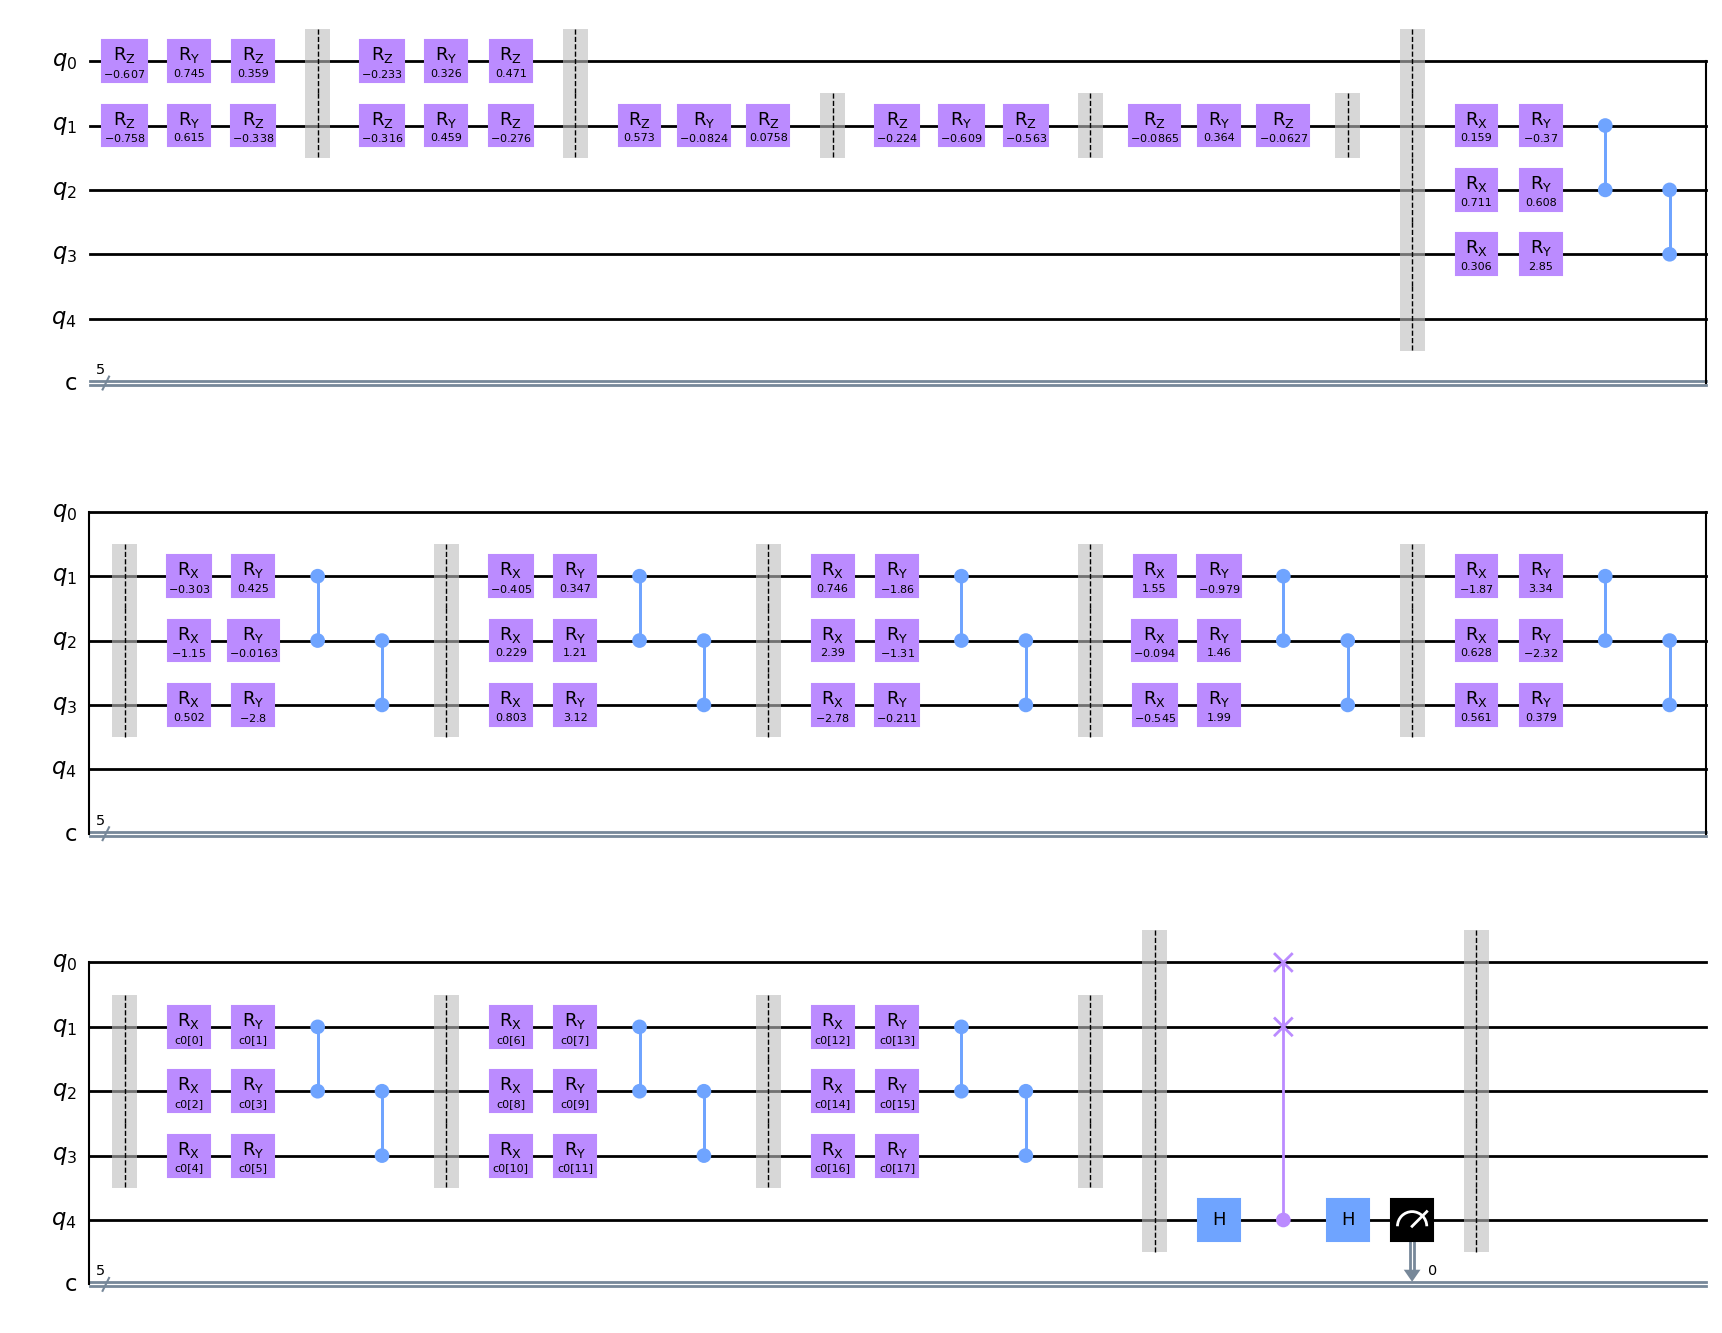

In [46]:
'''训练第三步去噪'''
time = 2
circlst3 = [QuantumCircuit(swapn,5) for num in range(mean)] #每个点独立的电路

for each in range(mean):

    randcp = [np.random.randint(0,repeat) for i in range(2)] #随机选取加噪去噪对
    
    for t in range(time): # reference diffusion 加噪
        circlst3[each].rz(thetalst[t][randcp[0]][0],0)
        circlst3[each].ry(thetalst[t][randcp[0]][1],0)
        circlst3[each].rz(thetalst[t][randcp[0]][2],0)
        circlst3[each].barrier([0])

    for t in range(ttime): # total diffusion 整体加噪
        circlst3[each].rz(thetalst[t][randcp[1]][0],1)
        circlst3[each].ry(thetalst[t][randcp[1]][1],1)
        circlst3[each].rz(thetalst[t][randcp[1]][2],1)
        circlst3[each].barrier([1])

    circlst3[each].barrier(np.arange(swapn))
    veclst.append(Statevector(circlst3[each])) #添加每个点的vector

#denoising process 加入第一二步去噪的结果
optimal_lst = [optimal_parameters_1, optimal_parameters_2]
for each in range(mean):
    a = 0
    for alpha in ['a','b']:
        thetalstalpha = [ParameterVector(f'{alpha}{each}',18) for each in range(mean)]
        for n in range(layers):
            for i in range(totalq):
                circlst3[each].rx(thetalstalpha[each][0+2*i+n*2*totalq],i+1)
                circlst3[each].ry(thetalstalpha[each][1+2*i+n*2*totalq],i+1)
            for i in range(totalq):
                if i<totalq-1:
                    circlst3[each].cz(i+1,i+2)
            circlst3[each].barrier(range(1,1+totalq))
        circlst3[each] = circlst3[each].assign_parameters({thetalstalpha[each]: optimal_lst[a]})
        a += 1

#denoising process 第三步去噪
layers = 3
thetalstc = [ParameterVector(f'c{each}',18) for each in range(mean)]

for each in range(mean):
    for n in range(layers):
        for i in range(totalq):
            circlst3[each].rx(thetalstc[each][0+2*i+n*2*totalq],i+1)
            circlst3[each].ry(thetalstc[each][1+2*i+n*2*totalq],i+1)
        for i in range(totalq):
            if i<totalq-1:
                circlst3[each].cz(i+1,i+2)
        circlst3[each].barrier(range(1,1+totalq))

    #swap test
    # circlst3[each].measure([2,3],[1,2]) #测量辅助比特
    circlst3[each].barrier(range(swapn))
    circlst3[each].h(4)
    circlst3[each].cswap(4,0,1)
    circlst3[each].h(4)
    circlst3[each].measure(4,0)
    circlst3[each].barrier(range(swapn))
circlst3[0].draw('mpl', style='iqp')


[-1.00761025  1.67525644  0.96085445 -1.03466927 -0.96328423 -0.87101159
 -0.31981894 -1.50283322 -0.22109837 -0.22357231  0.60289151 -1.62504107
  1.56208458 -0.49179636 -1.71080805 -0.58943885 -0.63045418  0.37694366]
54.44


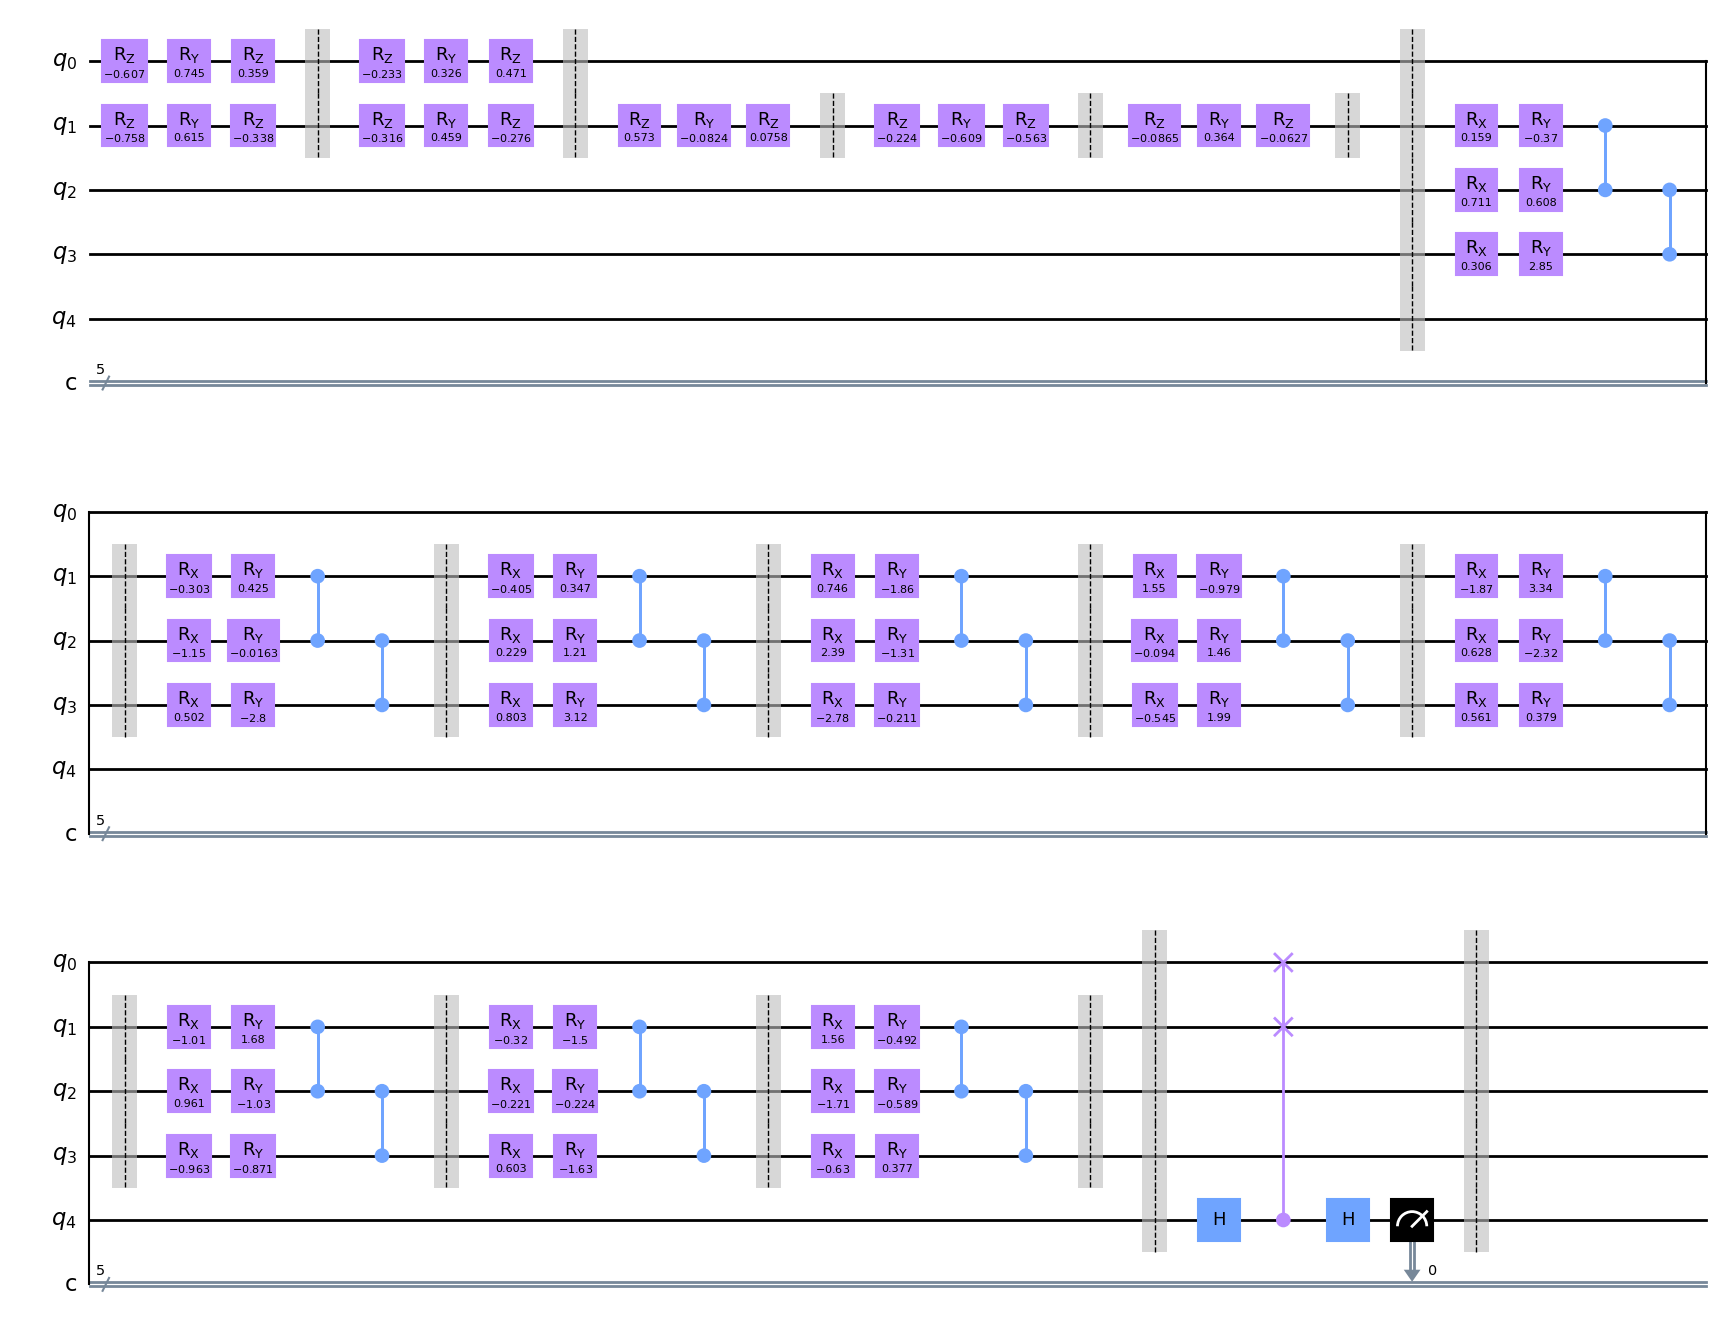

In [47]:
def cost_function_vqe_3(theta_range): #损失函数,这里xxxx0代表前向和后向重合,该值越大,去噪效果越好,因此需要最小xxxx1的频率
    count = 0
    for each in range(mean):
        circuits = circlst3[each].assign_parameters({thetalstc[each]: theta_range})
        job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)

        result_sim = job_sim.result()
        counts = result_sim.get_counts(circuits)

        for i in counts.keys():
            if i[-1]=='1':
                count += counts[i]
    return count/mean

### Optimizaion of denoising circuit parameters 优化参数

initial_theta = np.random.randn(18)
optimizer = SPSA(maxiter=200, blocking=True) # 可选参数如 maxiter=150, blocking=True 增强优化效果

optimizer_result = optimizer.minimize(fun=cost_function_vqe_3, x0=initial_theta)
optimal_parameters_3 = optimizer_result.x

print(optimal_parameters_3)
print(cost_function_vqe_3(optimal_parameters_3))

for each in range(mean):
    circlst3[each] = circlst3[each].assign_parameters({thetalstc[each]: optimal_parameters_3})
circlst3[0].draw('mpl', style='iqp') #最终训练后的电路

In [48]:
# with open('opp3.txt','w') as f:
#     f.write(str(optimal_parameters_3))

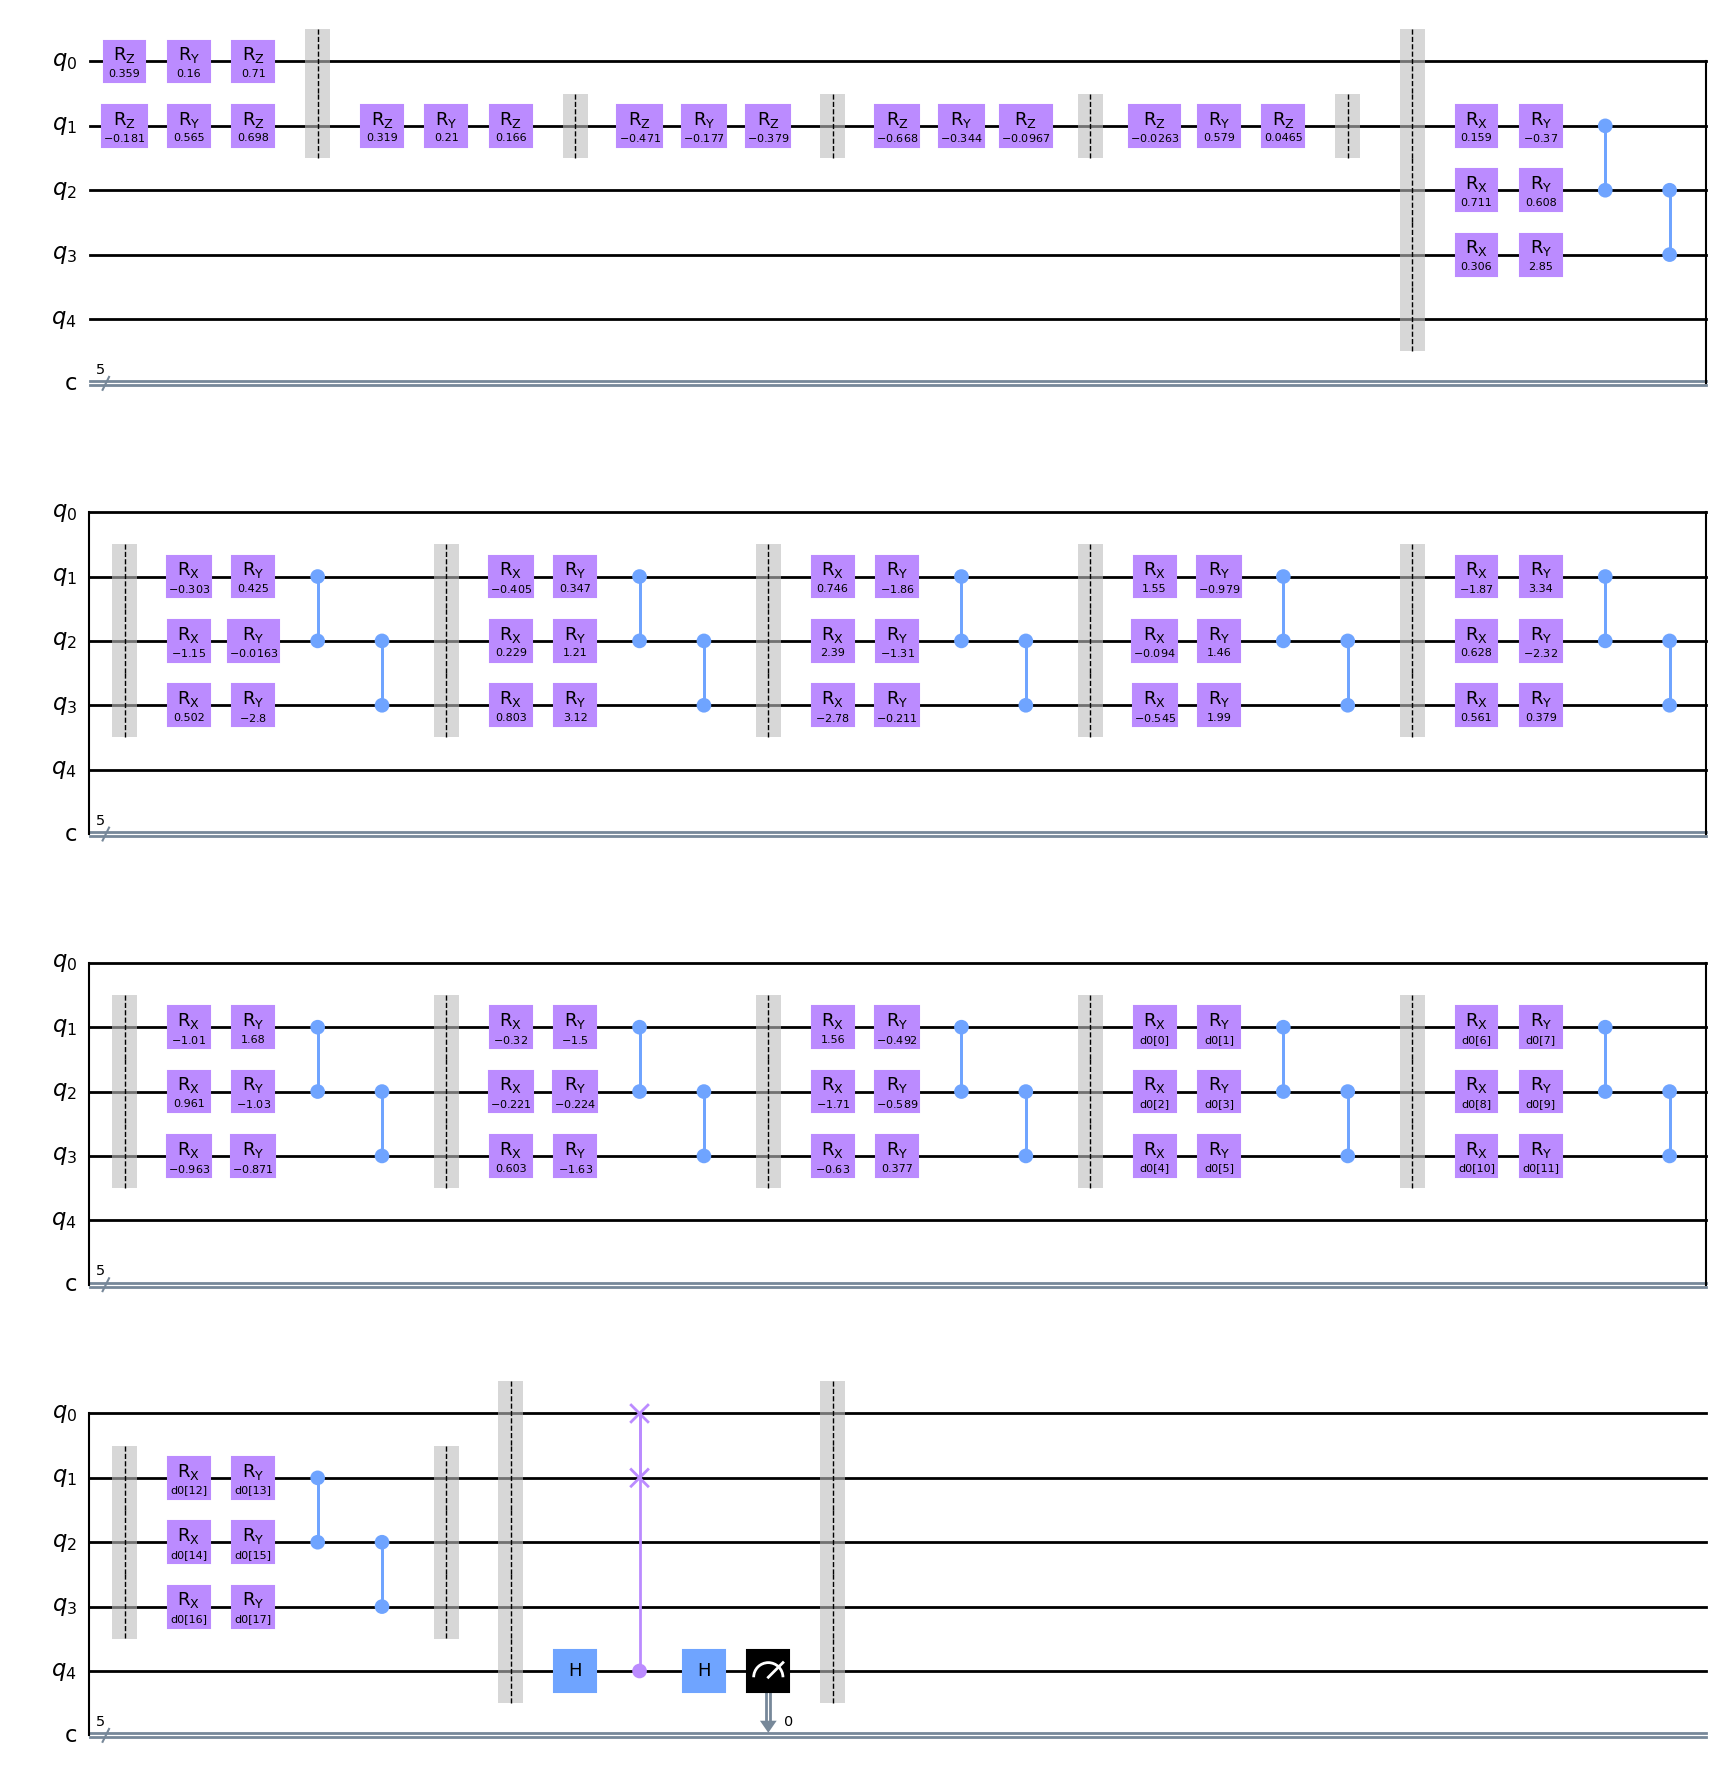

In [49]:
'''训练第四步去噪'''
time = 1
circlst4 = [QuantumCircuit(swapn,5) for num in range(mean)] #每个点独立的电路

for each in range(mean):

    randcp = [np.random.randint(0,repeat) for i in range(2)] #随机选取加噪去噪对
    
    for t in range(time): # reference diffusion 加噪
        circlst4[each].rz(thetalst[t][randcp[0]][0],0)
        circlst4[each].ry(thetalst[t][randcp[0]][1],0)
        circlst4[each].rz(thetalst[t][randcp[0]][2],0)
        circlst4[each].barrier([0])

    for t in range(ttime): # total diffusion 整体加噪
        circlst4[each].rz(thetalst[t][randcp[1]][0],1)
        circlst4[each].ry(thetalst[t][randcp[1]][1],1)
        circlst4[each].rz(thetalst[t][randcp[1]][2],1)
        circlst4[each].barrier([1])

    circlst4[each].barrier(np.arange(swapn))
    veclst.append(Statevector(circlst4[each])) #添加每个点的vector

#denoising process 加入第一二三步去噪的结果
optimal_lst = [optimal_parameters_1, optimal_parameters_2, optimal_parameters_3]
for each in range(mean):
    a = 0
    for alpha in ['a','b','c']:
        thetalstalpha = [ParameterVector(f'{alpha}{each}',18) for each in range(mean)]
        for n in range(layers):
            for i in range(totalq):
                circlst4[each].rx(thetalstalpha[each][0+2*i+n*2*totalq],i+1)
                circlst4[each].ry(thetalstalpha[each][1+2*i+n*2*totalq],i+1)
            for i in range(totalq):
                if i<totalq-1:
                    circlst4[each].cz(i+1,i+2)
            circlst4[each].barrier(range(1,1+totalq))
        circlst4[each] = circlst4[each].assign_parameters({thetalstalpha[each]: optimal_lst[a]})
        a += 1

#denoising process 第四步去噪
layers = 3
thetalstd = [ParameterVector(f'd{each}',18) for each in range(mean)]

for each in range(mean):
    for n in range(layers):
        for i in range(totalq):
            circlst4[each].rx(thetalstd[each][0+2*i+n*2*totalq],i+1)
            circlst4[each].ry(thetalstd[each][1+2*i+n*2*totalq],i+1)
        for i in range(totalq):
            if i<totalq-1:
                circlst4[each].cz(i+1,i+2)
        circlst4[each].barrier(range(1,1+totalq))

    #swap test
    # circlst4[each].measure([2,3],[1,2]) #测量辅助比特
    circlst4[each].barrier(range(swapn))
    circlst4[each].h(4)
    circlst4[each].cswap(4,0,1)
    circlst4[each].h(4)
    circlst4[each].measure(4,0)
    circlst4[each].barrier(range(swapn))
circlst4[0].draw('mpl', style='iqp')

[-1.19962668  0.44324538  0.57335428  0.33496171  0.08327609 -0.3655188
 -0.83548606 -0.09996029  0.6731654  -0.12431158 -0.42524569 -1.04582901
  0.67352315 -0.62294637  2.4252685   1.21164833  0.84206749 -0.6293167 ]
36.24


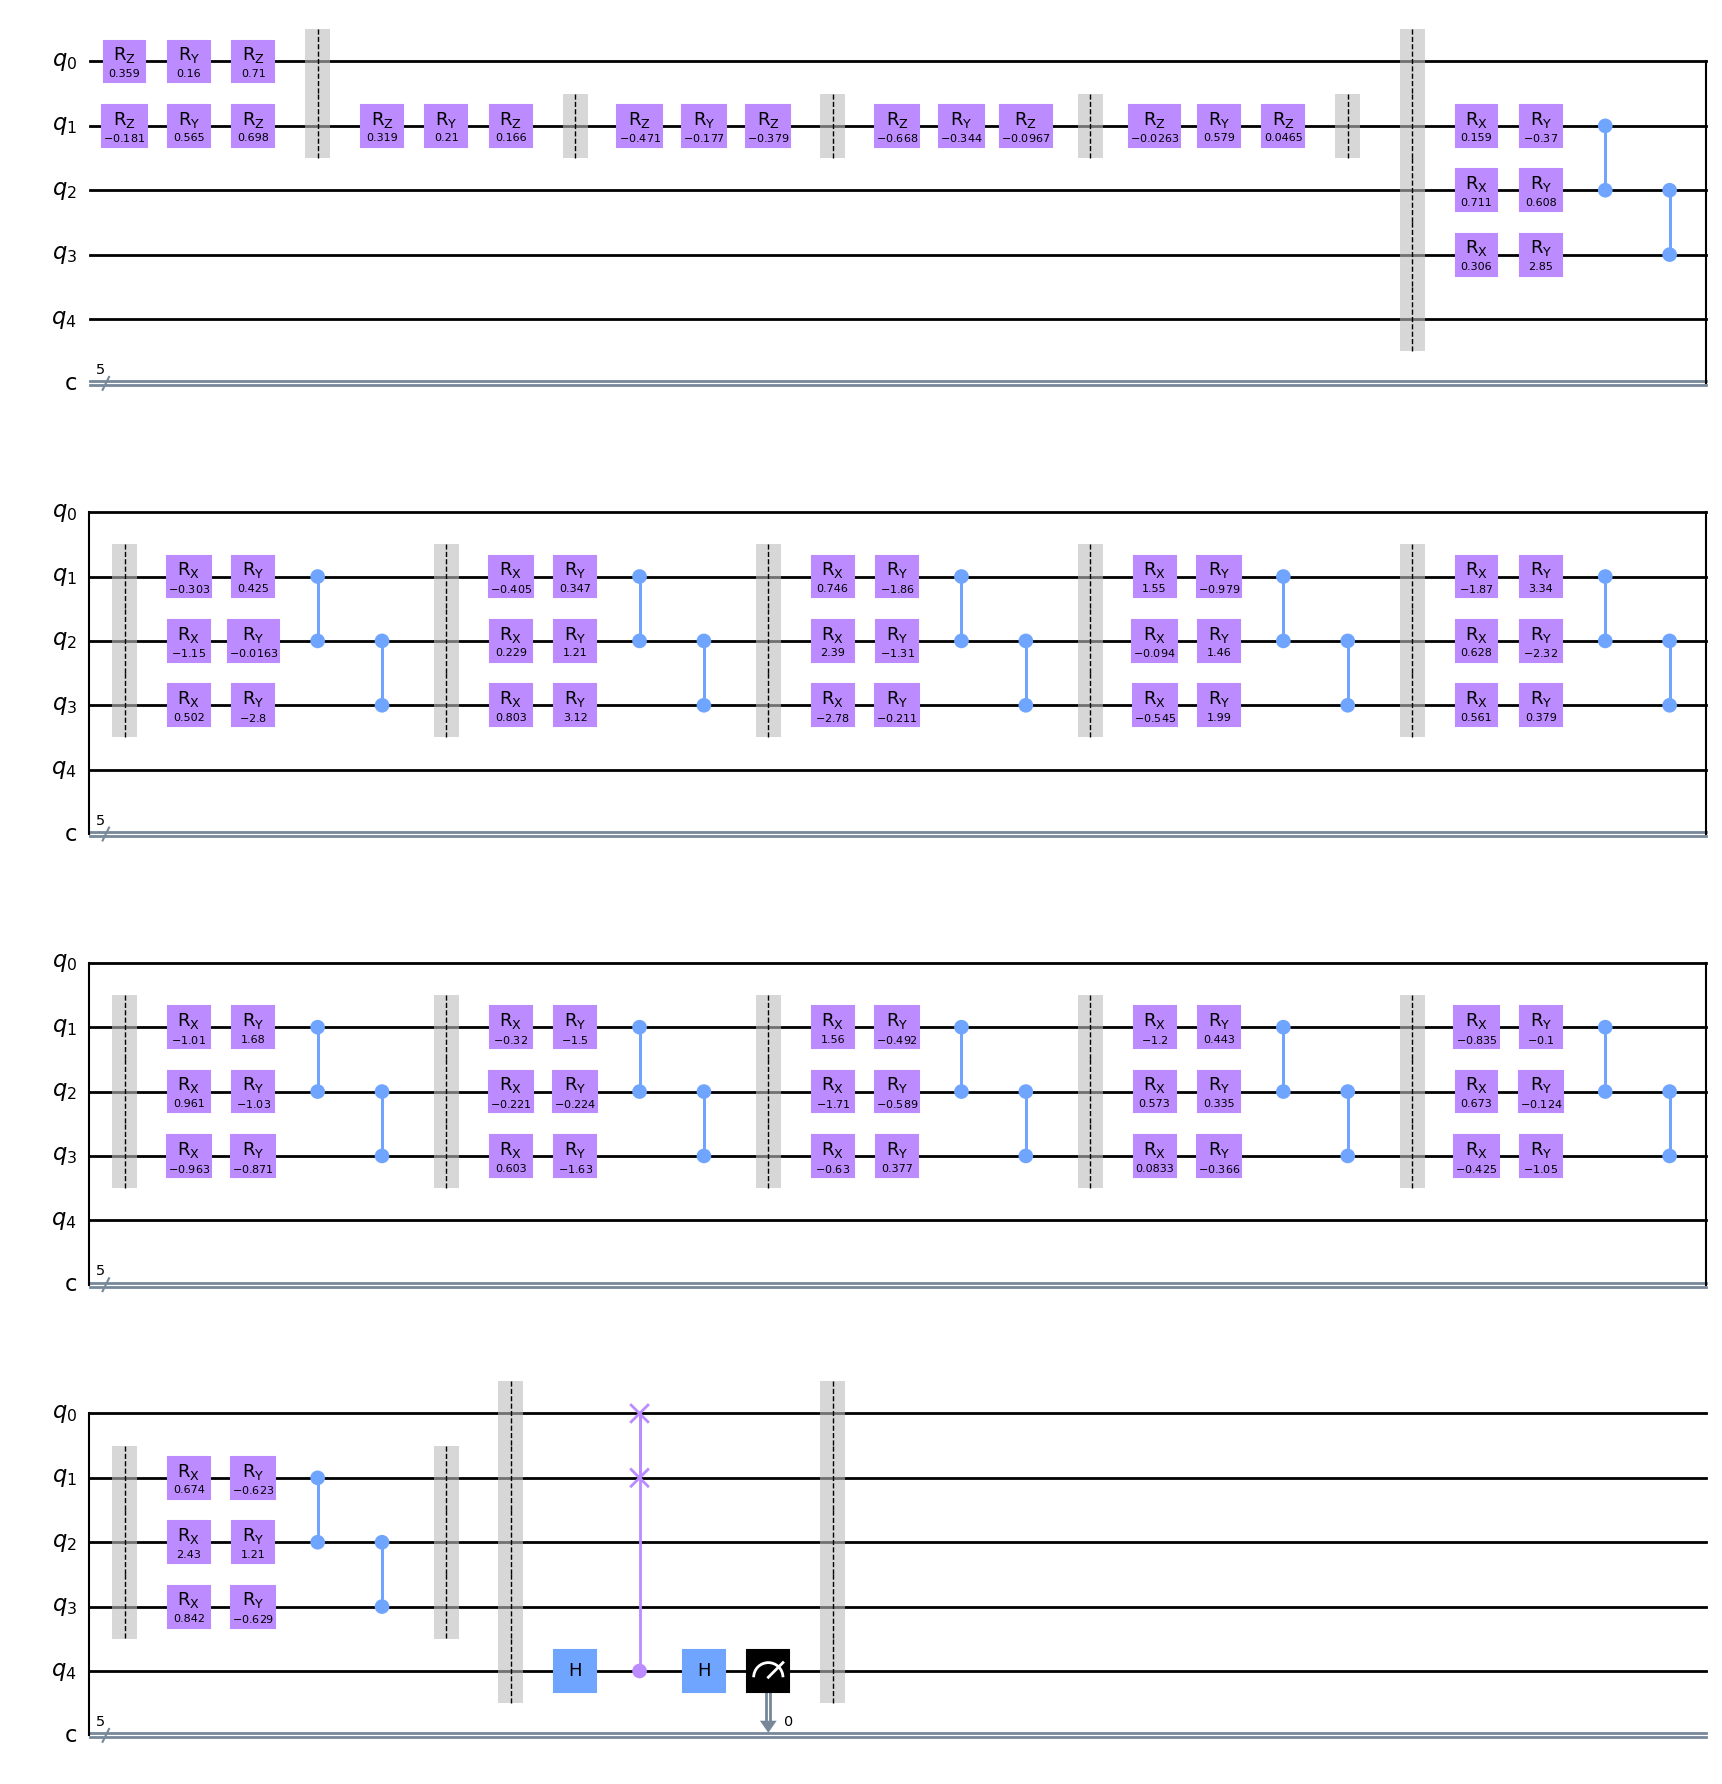

In [50]:
def cost_function_vqe_4(theta_range): #损失函数,这里xxxx0代表前向和后向重合,该值越大,去噪效果越好,因此需要最小xxxx1的频率
    count = 0
    for each in range(mean):
        circuits = circlst4[each].assign_parameters({thetalstd[each]: theta_range})
        job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)

        result_sim = job_sim.result()
        counts = result_sim.get_counts(circuits)

        for i in counts.keys():
            if i[-1]=='1':
                count += counts[i]
    return count/mean

### Optimizaion of denoising circuit parameters 优化参数

initial_theta = np.random.randn(18)
optimizer = SPSA(maxiter=200, blocking=True) 

optimizer_result = optimizer.minimize(fun=cost_function_vqe_4, x0=initial_theta)
optimal_parameters_4 = optimizer_result.x

print(optimal_parameters_4)
print(cost_function_vqe_4(optimal_parameters_4))

for each in range(mean):
    circlst4[each] = circlst4[each].assign_parameters({thetalstd[each]: optimal_parameters_4})
circlst4[0].draw('mpl', style='iqp') #最终训练后的电路

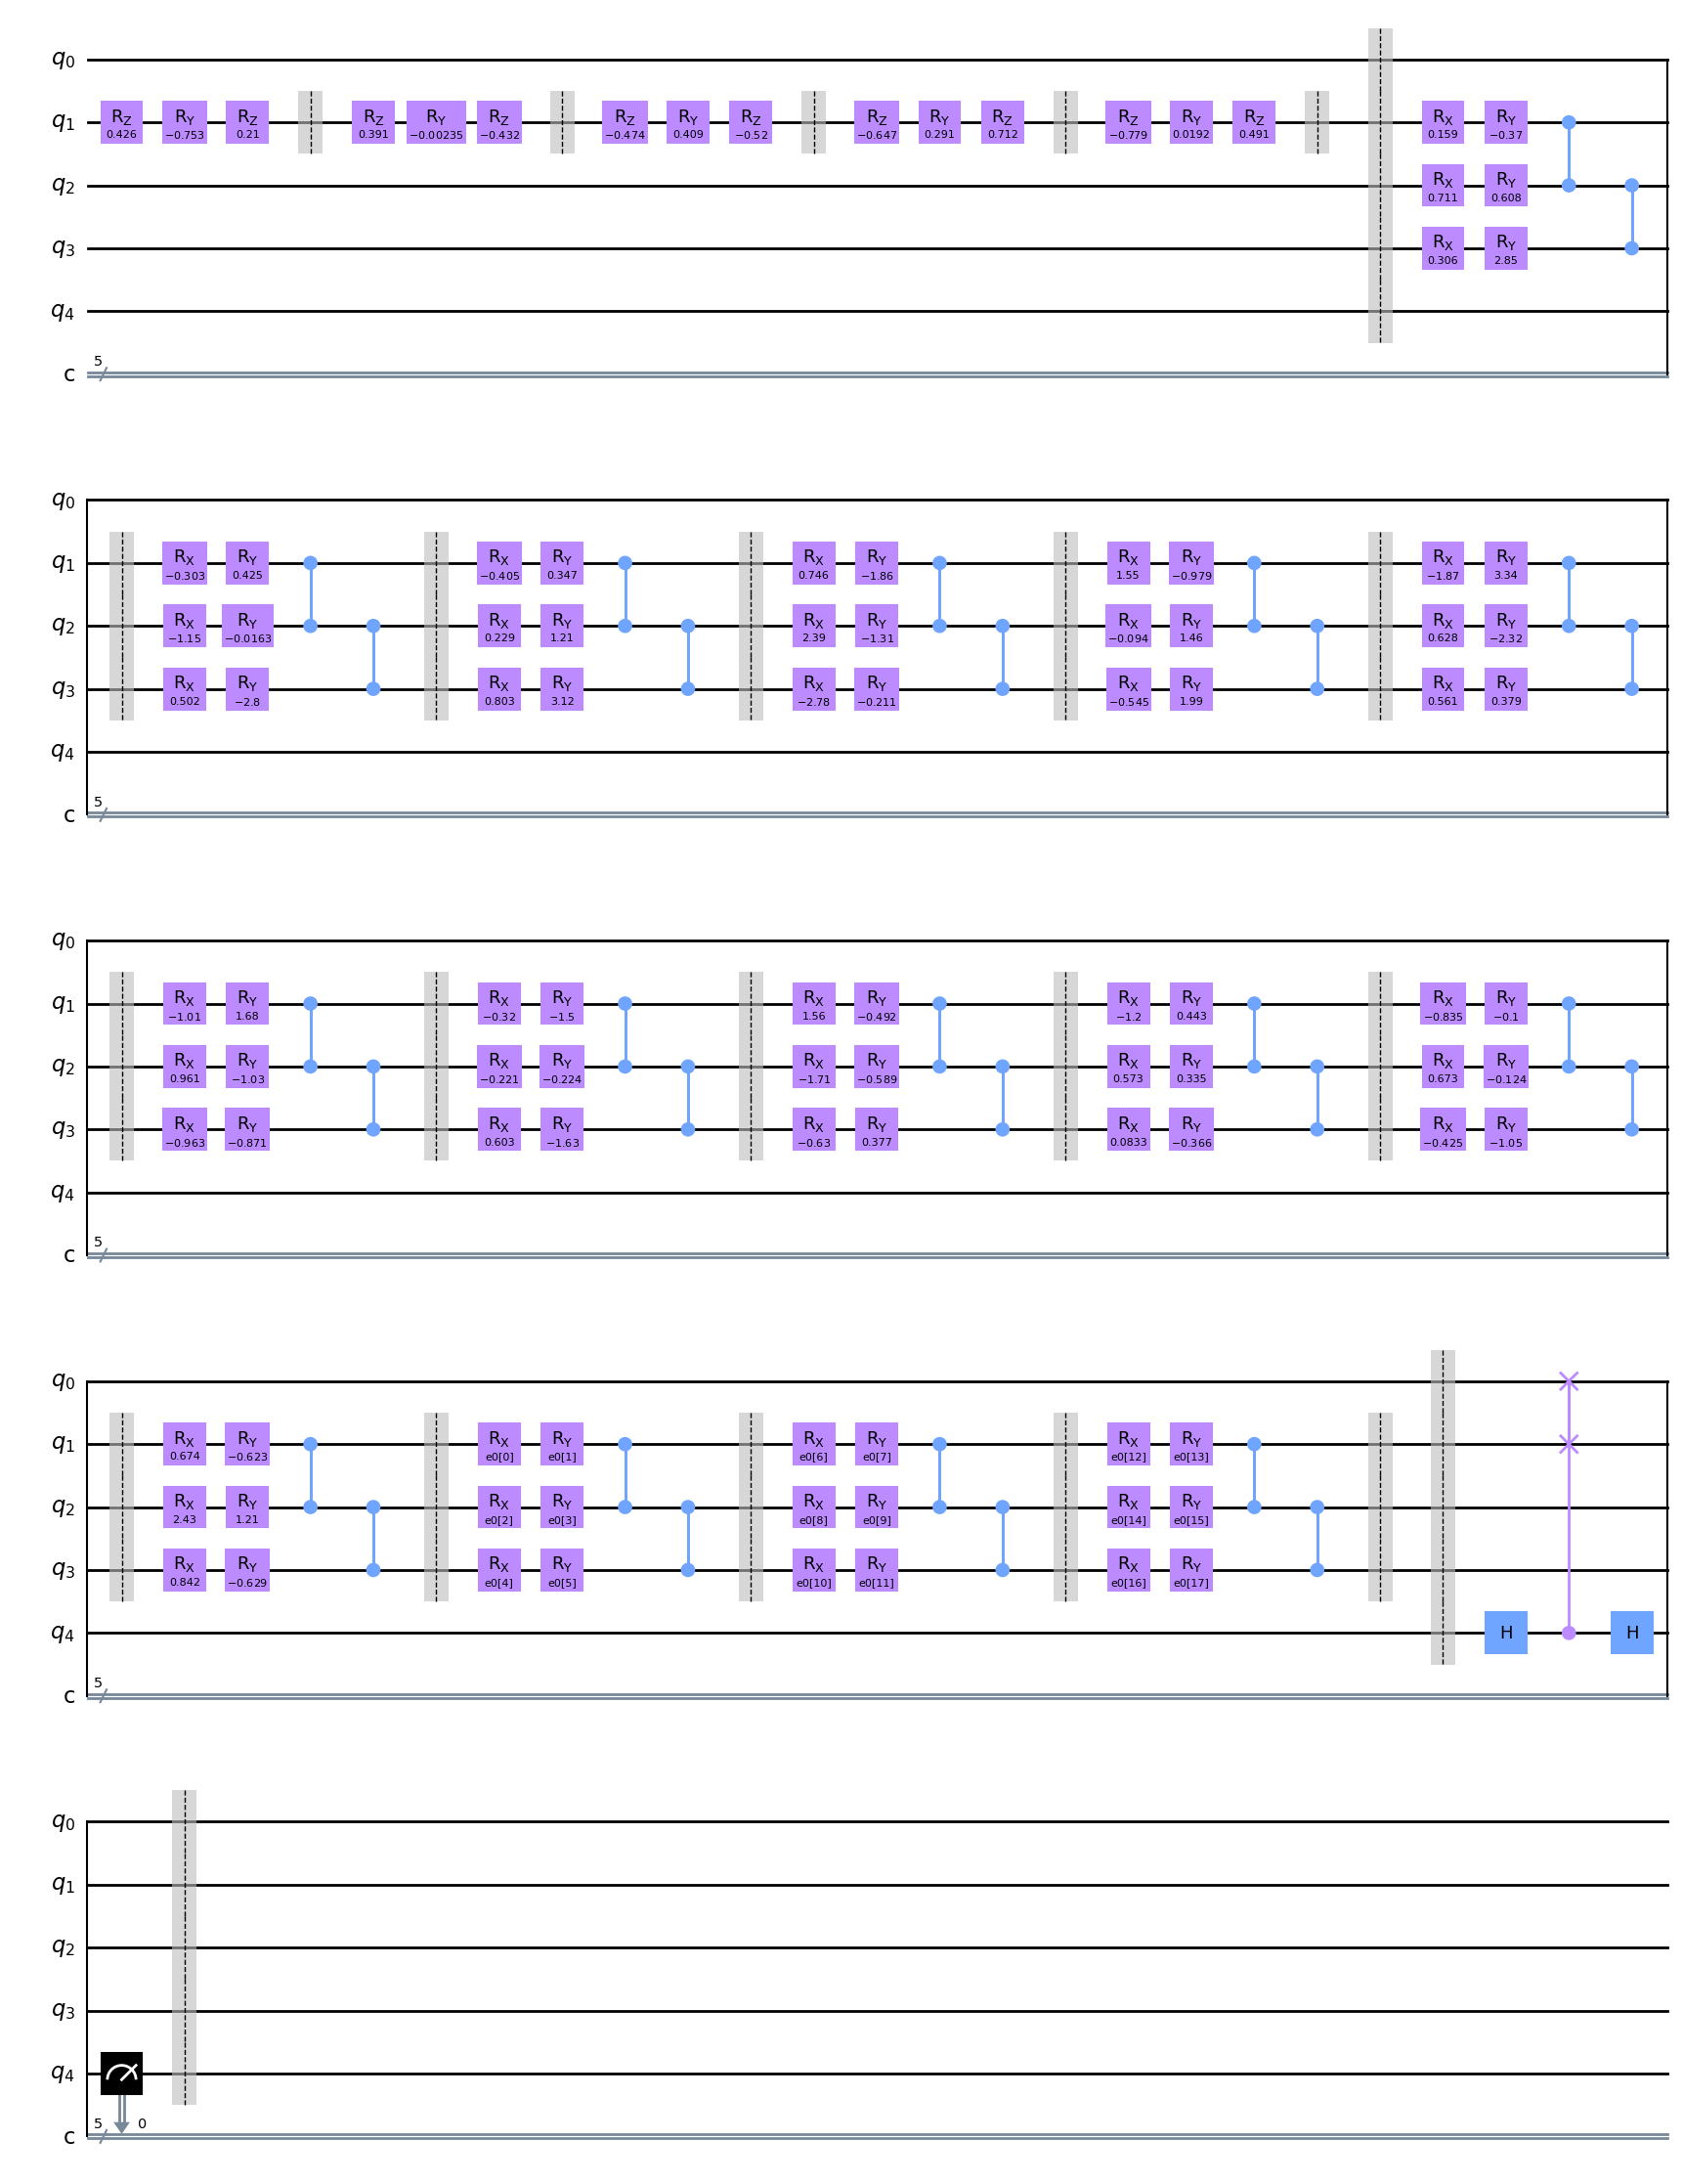

In [51]:
'''训练第五步去噪'''
time = 0
circlst5 = [QuantumCircuit(swapn,5) for num in range(mean)] #每个点独立的电路

for each in range(mean):

    randcp = [np.random.randint(0,repeat) for i in range(2)] #随机选取加噪去噪对
    
    for t in range(time): # reference diffusion 加噪
        circlst5[each].rz(thetalst[t][randcp[0]][0],0)
        circlst5[each].ry(thetalst[t][randcp[0]][1],0)
        circlst5[each].rz(thetalst[t][randcp[0]][2],0)
        circlst5[each].barrier([0])

    for t in range(ttime): # total diffusion 整体加噪
        circlst5[each].rz(thetalst[t][randcp[1]][0],1)
        circlst5[each].ry(thetalst[t][randcp[1]][1],1)
        circlst5[each].rz(thetalst[t][randcp[1]][2],1)
        circlst5[each].barrier([1])

    circlst5[each].barrier(np.arange(swapn))
    veclst.append(Statevector(circlst5[each])) #添加每个点的vector

#denoising process 加入第一二三四步去噪的结果
optimal_lst = [optimal_parameters_1, optimal_parameters_2, optimal_parameters_3, optimal_parameters_4]
for each in range(mean):
    a = 0
    for alpha in ['a','b','c','d']:
        thetalstalpha = [ParameterVector(f'{alpha}{each}',18) for each in range(mean)]
        for n in range(layers):
            for i in range(totalq):
                circlst5[each].rx(thetalstalpha[each][0+2*i+n*2*totalq],i+1)
                circlst5[each].ry(thetalstalpha[each][1+2*i+n*2*totalq],i+1)
            for i in range(totalq):
                if i<totalq-1:
                    circlst5[each].cz(i+1,i+2)
            circlst5[each].barrier(range(1,1+totalq))
        circlst5[each] = circlst5[each].assign_parameters({thetalstalpha[each]: optimal_lst[a]})
        a += 1

#denoising process 第五步去噪
layers = 3
thetalste = [ParameterVector(f'e{each}',18) for each in range(mean)]

for each in range(mean):
    for n in range(layers):
        for i in range(totalq):
            circlst5[each].rx(thetalste[each][0+2*i+n*2*totalq],i+1)
            circlst5[each].ry(thetalste[each][1+2*i+n*2*totalq],i+1)
        for i in range(totalq):
            if i<totalq-1:
                circlst5[each].cz(i+1,i+2)
        circlst5[each].barrier(range(1,1+totalq))

    #swap test
    # circlst5[each].measure([2,3],[1,2]) #测量辅助比特
    circlst5[each].barrier(range(swapn))
    circlst5[each].h(4)
    circlst5[each].cswap(4,0,1)
    circlst5[each].h(4)
    circlst5[each].measure(4,0)
    circlst5[each].barrier(range(swapn))
circlst5[0].draw('mpl', style='iqp')

In [52]:
def cost_function_vqe_5(theta_range): #损失函数,这里xxxx0代表前向和后向重合,该值越大,去噪效果越好,因此需要最小xxxx1的频率
    count = 0
    for each in range(mean):
        circuits = circlst5[each].assign_parameters({thetalste[each]: theta_range})
        job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)

        result_sim = job_sim.result()
        counts = result_sim.get_counts(circuits)

        for i in counts.keys():
            if i[-1]=='1':
                count += counts[i]
    return count/mean

### Optimizaion of denoising circuit parameters 优化参数

initial_theta = np.random.randn(18)
optimizer = SPSA(maxiter=200, blocking=True) # 可选参数如 maxiter=150, blocking=True 增强优化效果

optimizer_result = optimizer.minimize(fun=cost_function_vqe_5, x0=initial_theta)
optimal_parameters_5 = optimizer_result.x

print(optimal_parameters_5)
print(cost_function_vqe_5(optimal_parameters_5))


[ 0.63107306  2.17588402 -1.66951639 -1.06444431  2.81667823 -2.3566856
  0.33669089 -0.70394466  0.32248367  0.64685455  0.71305059  2.10575412
 -2.54964551 -1.24204627 -0.83567681 -1.18398779  1.85350395  0.17863253]
16.28


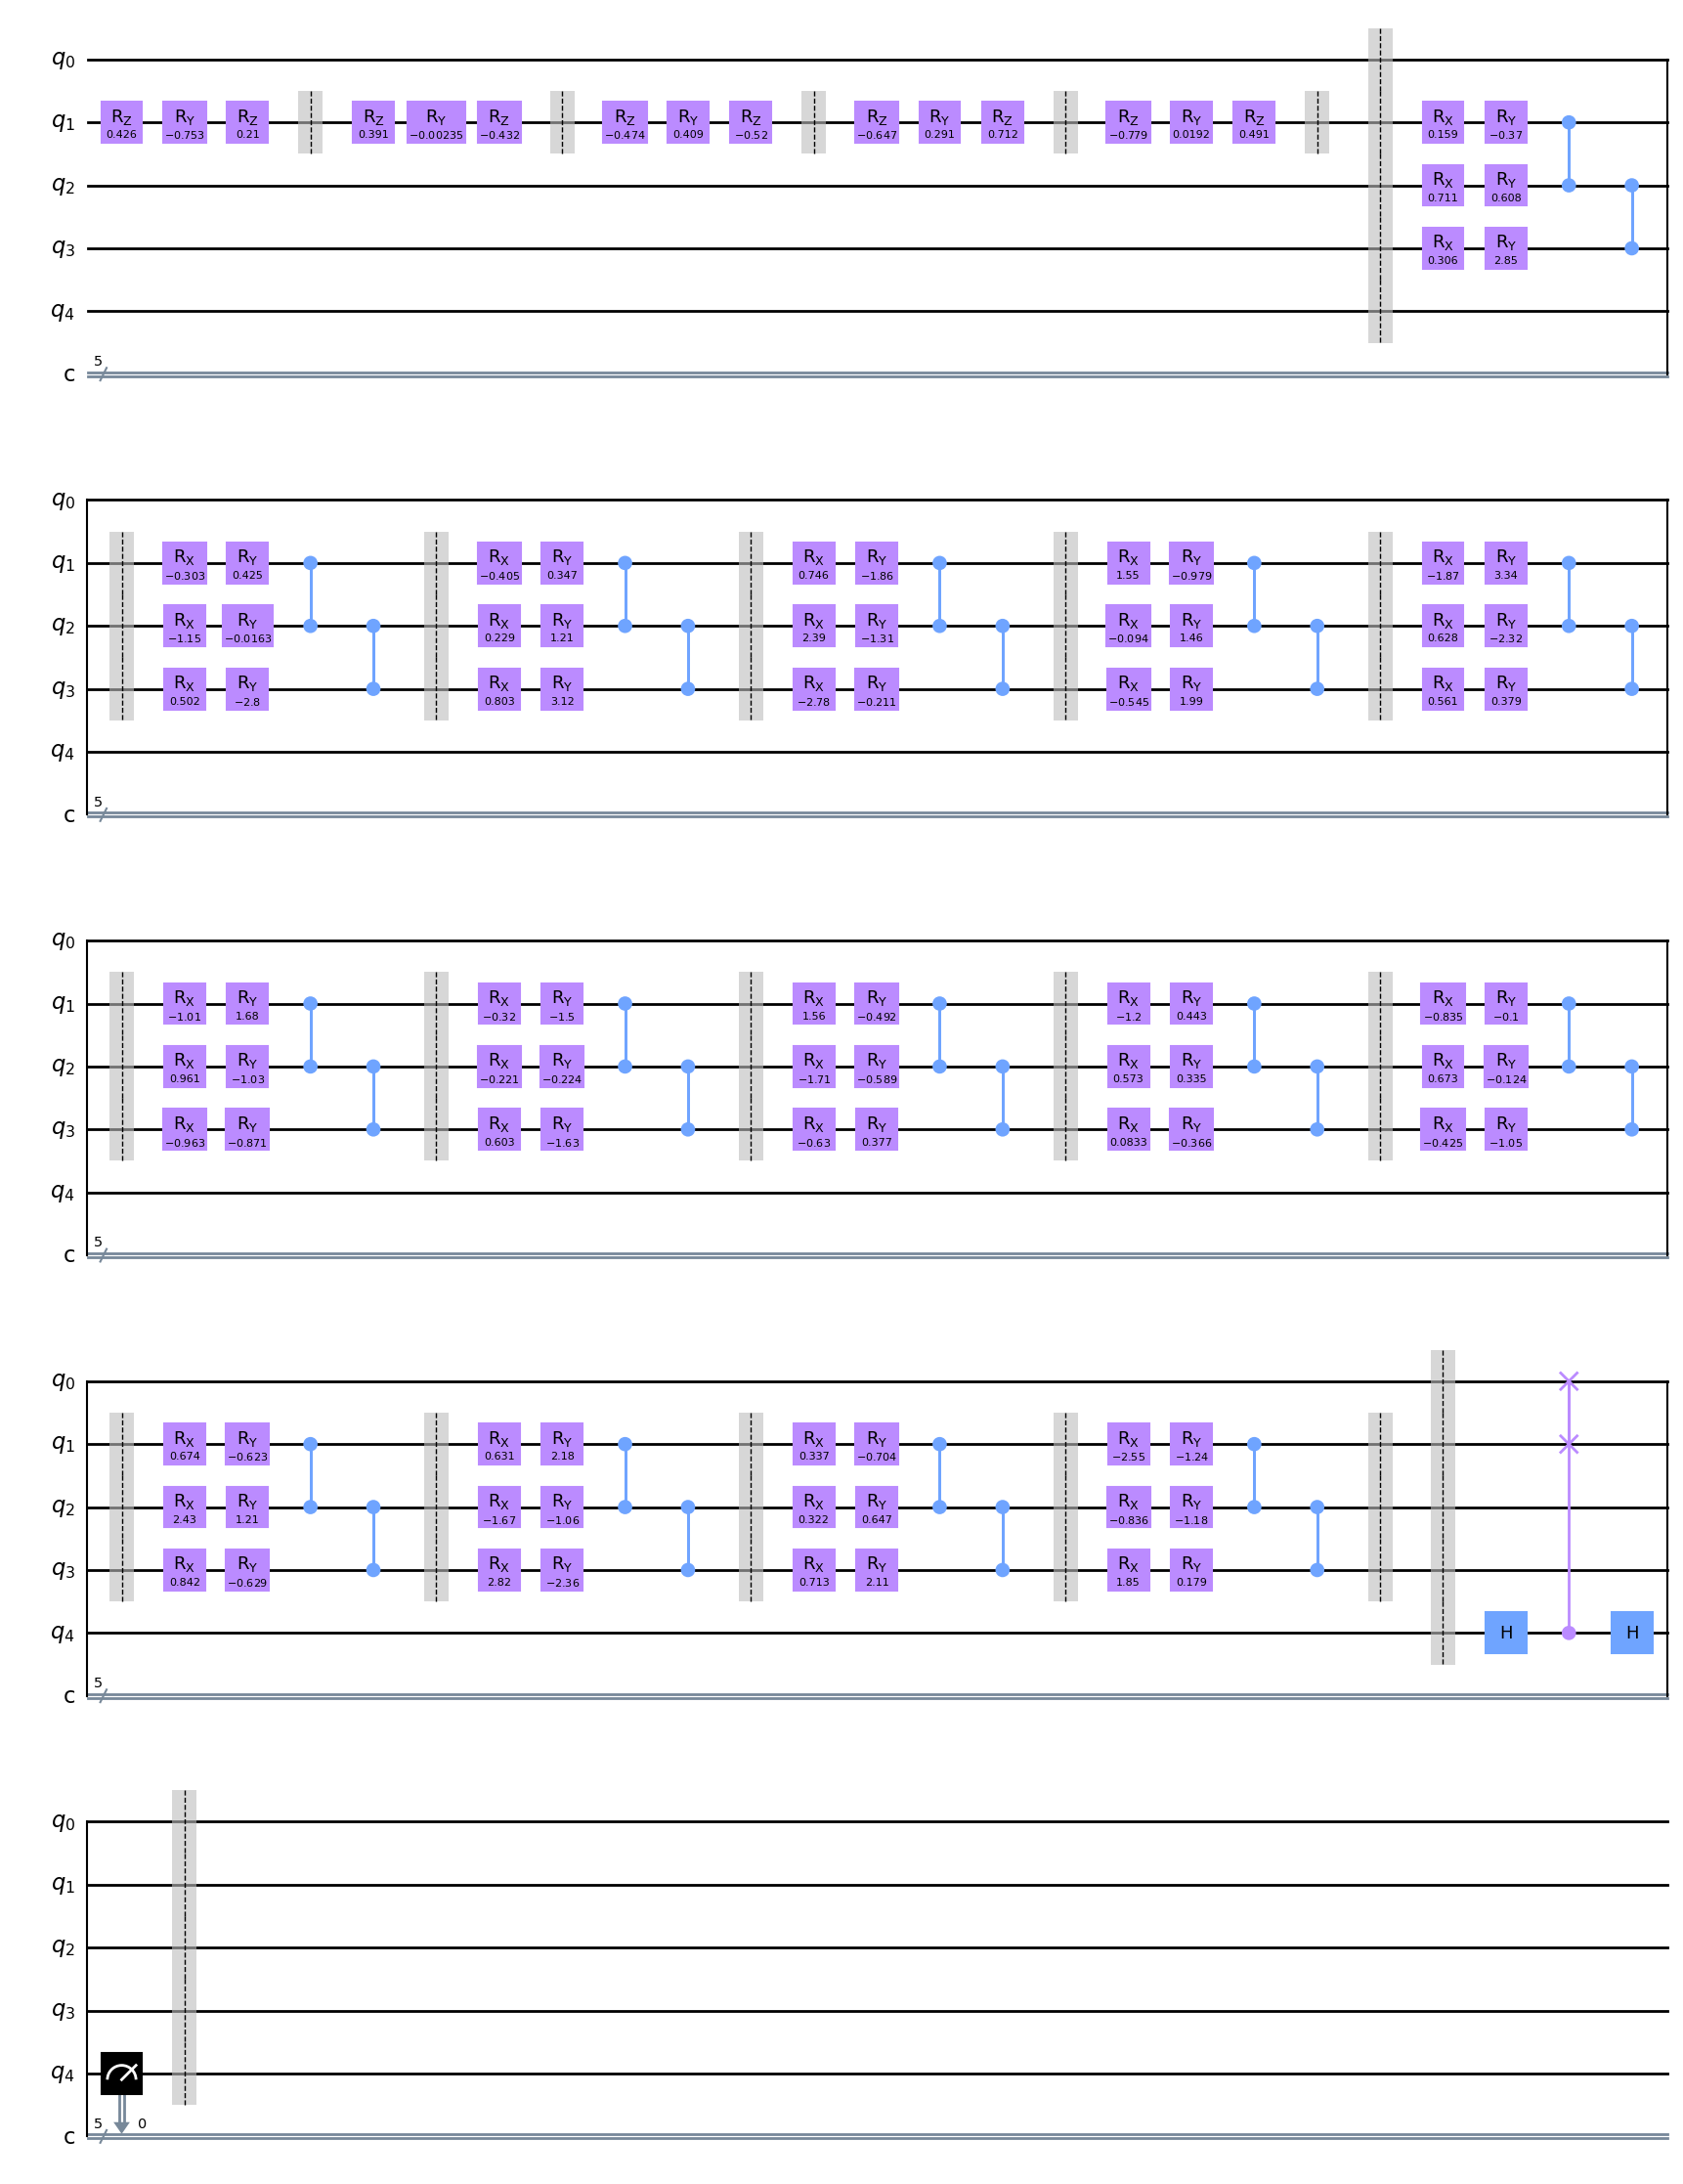

In [53]:
for each in range(mean):
    circlst5[each] = circlst5[each].assign_parameters({thetalste[each]: optimal_parameters_5})
circlst5[0].draw('mpl', style='iqp') #最终训练后的电路

现在我们构建训练后整体的加噪去噪电路

In [54]:
def msmt(cir):
    ## 对去噪后的量子比特在x,y,z方向进行测量，进而画出布洛赫球上的点
    xl=[]
    yl=[]
    zl=[]
    eps=10e-10
    for each in range(repeat):
        cir1 = cir[each].copy()
        cir2 = cir[each].copy()
        cir3 = cir[each].copy()

        cir1.measure([1,2,3],[0,1,2]) #z
        # cir1.measure(1,0) #z

        cir2.sdg(1)
        cir2.h(1)
        cir2.measure([1,2,3],[0,1,2])#y

        cir3.h(1)
        cir3.measure([1,2,3],[0,1,2])#x

        job_sim = backend_sim.run(transpile(cir1, backend_sim), shots=1024)
        result_sim = job_sim.result()
        counts1 = result_sim.get_counts(cir1)
        count1 = 0
        for i in counts1.keys():
                if i[-1]=='1':
                    count1 += counts1[i]
            
        z = ((1024-count1)/1024)
        z = (z-0.5)*2
        
        # plot_histogram(counts1)

        job_sim = backend_sim.run(transpile(cir2, backend_sim), shots=1024)
        result_sim = job_sim.result()
        counts2 = result_sim.get_counts(cir2)
        count2 = 0
        for i in counts2.keys():
                if i[-1]=='1':
                    count2 += counts2[i]
        y = ((1024-count2)/1024)
        y = (y-0.5)*2
        
        # plot_histogram(counts2)

        job_sim = backend_sim.run(transpile(cir3, backend_sim), shots=1024)
        result_sim = job_sim.result()
        counts3 = result_sim.get_counts(cir3)
        count3 = 0
        for i in counts3.keys():
                if i[-1]=='1':
                    count3 += counts3[i]
        x = ((1024-count3)/1024)
        x = (x-0.5)*2
        
        # plot_histogram(counts3)

        # x *= np.sqrt((1-z**2)/(x**2+y**2+eps))
        # y *= np.sqrt((1-z**2)/(x**2+y**2+eps))
        
        zl.append(z)
        yl.append(y)
        xl.append(x)

    return xl, yl, zl

In [55]:
optimal_lst = [optimal_parameters_1, optimal_parameters_2, optimal_parameters_3, optimal_parameters_4, optimal_parameters_5]

In [56]:
# 由于每次优化效果不同，我们选择一组去噪效果最好的一组参数。若想使用自己的优化参数，只需注释掉本代码块最后一行即可。此处我们用刚刚训练的参数。
e1 = [0.47811519, -1.28243318, -0.34468127,  1.58604246,  3.0855075,   3.17737532,
 -1.72590373, -3.66959171,  1.38418043, -1.22051186, -2.79575325, -2.78166456,
 -1.52085024,  3.23025266,  1.32906181, -0.68451842, -0.85414479,  1.75896589]
e2 = [-2.94500079, -9.15952836, -2.70710937, -2.12119686,  2.04997022, -4.8108007,
  3.19900847,  6.16492025 , 3.1060788,  -6.79494829 , 1.3418611 ,  5.9712664,
  6.23160971,  2.73555504 , 3.76938464 , 0.81508364 , 2.84045284 ,-6.02311165]
e3 = [ 0.48285752, -2.0564873 , -3.11518054, -1.85604518,  3.34659663 , 2.79342053,
  2.64325402,  0.66624015,  3.59932578, -2.79785339 , 2.57637 ,   -1.84814658,
 -3.38226121,  1.78462436, -1.59373352,  0.78845304 , 2.72871745,  3.1370888 ]
e4 = [-0.03256108,  0.06787217, -0.26857588, -0.17287145, -0.85176827, -0.42968895,
  0.01071522,  0.03132286, -0.19517695, -2.78867376 ,-1.01924547, -2.02494688,
 -0.0272261 ,  0.14830548 , 1.23589865 , 1.55764212 , 1.13048489,  2.89530156]
e5 = [ 1.78025971, -1.75778757,  1.01912588 , 1.42971676, -1.38062086, -0.33247566,
 -0.57652403,  0.7686767,   0.00916964, -0.25061125, -0.21165494, -1.43536161,
 -1.74767494, -0.49676494, -0.76284813, -1.28308609,  0.83737329, -0.11872478]
optimal_lst = [e1,e2,e3,e4,e5]

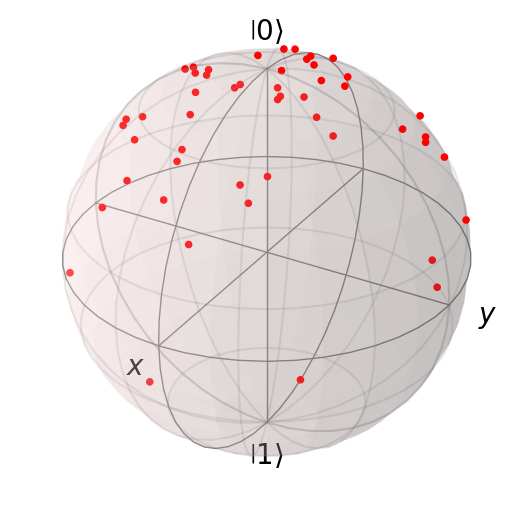

In [57]:
'''去噪前'''

cir = [QuantumCircuit(4,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        cir[each].rz(thetalst[t][each][0],1)
        cir[each].ry(thetalst[t][each][1],1)
        cir[each].rz(thetalst[t][each][2],1)
        cir[each].barrier([1])

    cir[each].barrier(np.arange(4))
    

xl, yl, zl = msmt(cir)

b = Bloch()
b.add_points([xl,yl,zl], "m")
b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']
b.show()

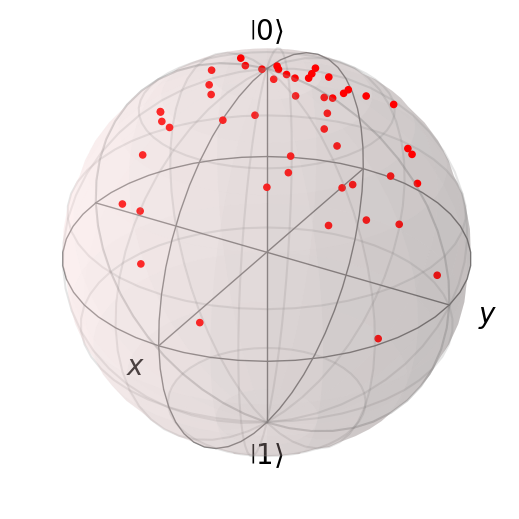

In [58]:
'''第一步去噪'''

cir = [QuantumCircuit(4,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        cir[each].rz(thetalst[t][each][0],1)
        cir[each].ry(thetalst[t][each][1],1)
        cir[each].rz(thetalst[t][each][2],1)
        cir[each].barrier([1])

    cir[each].barrier(np.arange(4))
    
#denoising process 加入第一步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    thetalsta = [ParameterVector(f'a{each}',18) for each in range(repeat)]

    for n in range(layers):
        for i in range(totalq):
            cir[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+1)
            cir[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+1)
        for i in range(totalq):
            if i<totalq-1:
                cir[each].cz(i+1,i+2)
        cir[each].barrier(range(1,1+totalq))

    cir[each] = cir[each].assign_parameters({thetalsta[each]: optimal_parameters_1})
cir[0].draw('mpl', style='iqp')
xl, yl, zl = msmt(cir)

b = Bloch()
b.add_points([xl,yl,zl], "m")
b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']
b.show()

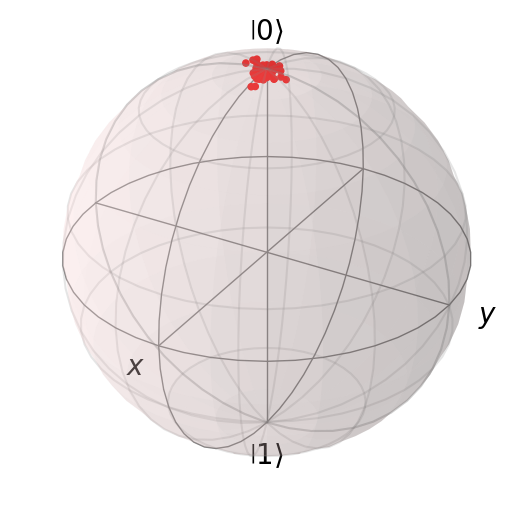

In [59]:
'''第二步去噪'''

cir = [QuantumCircuit(4,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        cir[each].rz(thetalst[t][each][0],1)
        cir[each].ry(thetalst[t][each][1],1)
        cir[each].rz(thetalst[t][each][2],1)
        cir[each].barrier([1])

    cir[each].barrier(np.arange(4))
    
#denoising process 加入第一二步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    a = 0
    for alpha in ['a','b']:
        thetalsta = [ParameterVector(f'{alpha}{each}',18) for each in range(repeat)]
        for n in range(layers):
            for i in range(totalq):
                cir[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+1)
                cir[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+1)
            for i in range(totalq):
                if i<totalq-1:
                    cir[each].cz(i+1,i+2)
            cir[each].barrier(range(1,1+totalq))
        cir[each] = cir[each].assign_parameters({thetalsta[each]: optimal_lst[a]})
        a += 1

cir[0].draw('mpl', style='iqp')
xl, yl, zl = msmt(cir)

b = Bloch()
b.add_points([xl,yl,zl], "m")
b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']
b.show()

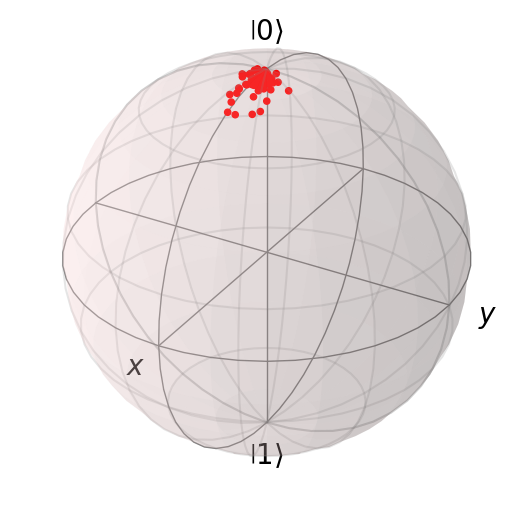

In [60]:
'''第三步去噪'''

cir = [QuantumCircuit(4,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        cir[each].rz(thetalst[t][each][0],1)
        cir[each].ry(thetalst[t][each][1],1)
        cir[each].rz(thetalst[t][each][2],1)
        cir[each].barrier([1])

    cir[each].barrier(np.arange(4))
    
cir[0].draw('mpl', style='iqp')

#denoising process 加入第一二三步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    a = 0
    for alpha in ['a','b','c']:
        thetalsta = [ParameterVector(f'{alpha}{each}',18) for each in range(repeat)]
        for n in range(layers):
            for i in range(totalq):
                cir[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+1)
                cir[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+1)
            for i in range(totalq):
                if i<totalq-1:
                    cir[each].cz(i+1,i+2)
            cir[each].barrier(range(1,1+totalq))
        cir[each] = cir[each].assign_parameters({thetalsta[each]: optimal_lst[a]})
        a += 1
cir[1].draw('mpl', style='iqp')
xl, yl, zl = msmt(cir)

b = Bloch()
b.add_points([xl,yl,zl], "m")
b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']
b.show()

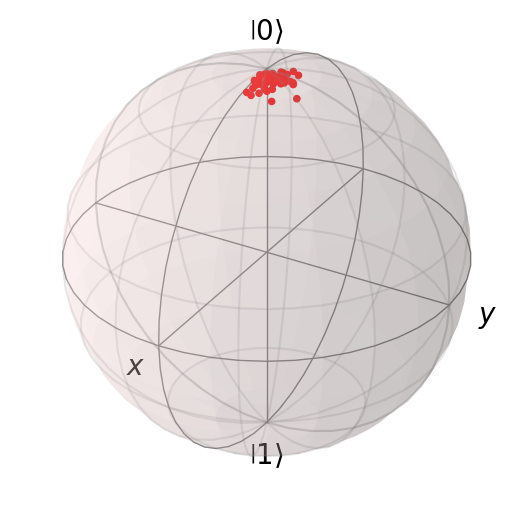

In [61]:
'''第四步去噪'''

cir = [QuantumCircuit(4,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        cir[each].rz(thetalst[t][each][0],1)
        cir[each].ry(thetalst[t][each][1],1)
        cir[each].rz(thetalst[t][each][2],1)
        cir[each].barrier([1])

    cir[each].barrier(np.arange(4))

#denoising process 加入第一二三四步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    a = 0
    for alpha in ['a','b','c','d']:
        thetalsta = [ParameterVector(f'{alpha}{each}',18) for each in range(repeat)]
        for n in range(layers):
            for i in range(totalq):
                cir[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+1)
                cir[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+1)
            for i in range(totalq):
                if i<totalq-1:
                    cir[each].cz(i+1,i+2)
            cir[each].barrier(range(1,1+totalq))
        cir[each] = cir[each].assign_parameters({thetalsta[each]: optimal_lst[a]})
        a += 1

        
xl, yl, zl = msmt(cir)

b = Bloch()
b.add_points([xl,yl,zl], "m")
b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']
b.show()

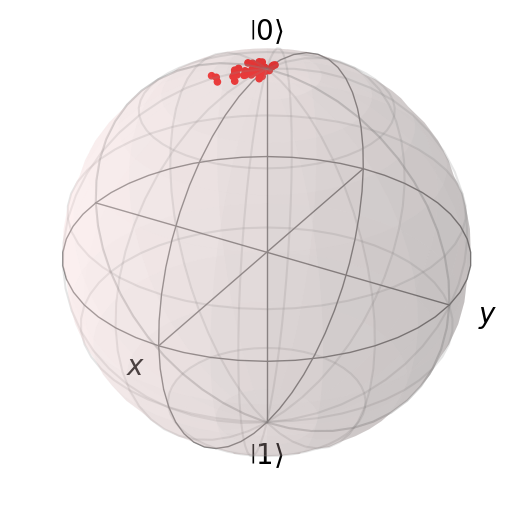

In [62]:
'''第五步去噪'''

cir = [QuantumCircuit(4,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        cir[each].rz(thetalst[t][each][0],1)
        cir[each].ry(thetalst[t][each][1],1)
        cir[each].rz(thetalst[t][each][2],1)
        cir[each].barrier([1])

    cir[each].barrier(np.arange(4))

#denoising process 加入第一二三四五步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    a = 0
    for alpha in ['a','b','c','d','e']:
        thetalsta = [ParameterVector(f'{alpha}{each}',18) for each in range(repeat)]
        for n in range(layers):
            for i in range(totalq):
                cir[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+1)
                cir[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+1)
            for i in range(totalq):
                if i<totalq-1:
                    cir[each].cz(i+1,i+2)
            cir[each].barrier(range(1,1+totalq))
        cir[each] = cir[each].assign_parameters({thetalsta[each]: optimal_lst[a]})
        a += 1

        
xl, yl, zl = msmt(cir)

b = Bloch()
b.add_points([xl,yl,zl], "m")
b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']
b.show()

测试完全混态的去噪效果

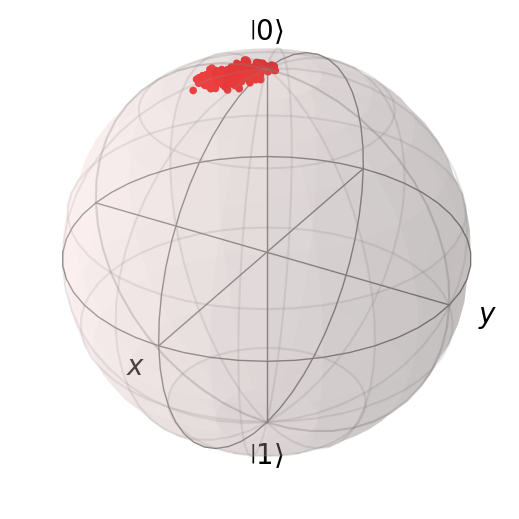

In [63]:
repeat = 200
cir = [QuantumCircuit(4,3) for each in range(repeat)]

for each in range(repeat):
    np.random.seed(each)
    for t in range(30): # total diffusion 整体加噪
        random_thetalst = (np.random.rand(3*qbt)-0.5)*theta_scale
        cir[each].rz(random_thetalst[0],1)
        cir[each].ry(random_thetalst[1],1)
        cir[each].rz(random_thetalst[2],1)
        cir[each].barrier([1])

    cir[each].barrier(np.arange(4))
    
# cir[0].draw('mpl', style='iqp')

#denoising process 加入第一二三四五步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    a = 0
    for alpha in ['a','b','c','d','e']:
        thetalsta = [ParameterVector(f'{alpha}{each}',18) for each in range(repeat)]
        for n in range(layers):
            for i in range(totalq):
                cir[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+1)
                cir[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+1)
            for i in range(totalq):
                if i<totalq-1:
                    cir[each].cz(i+1,i+2)
            cir[each].barrier(range(1,1+totalq))
        cir[each] = cir[each].assign_parameters({thetalsta[each]: optimal_lst[a]})
        a += 1

xl, yl, zl = msmt(cir)

b = Bloch()
b.add_points([xl,yl,zl], "m")
b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']
b.show()

可见效果明显